In [ ]:
!unzip drive/MyDrive/Proj3.zip
!du -sh Proj3/*


Archive:  drive/MyDrive/Proj3.zip
   creating: Proj3/
  inflating: Proj3/test_identity.csv  
  inflating: Proj3/train_identity.csv  
  inflating: Proj3/sample_submission.csv  
  inflating: Proj3/train_transaction.csv  
  inflating: Proj3/test_transaction.csv  
5.9M	Proj3/sample_submission.csv
25M	Proj3/test_identity.csv
585M	Proj3/test_transaction.csv
26M	Proj3/train_identity.csv
652M	Proj3/train_transaction.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1

### reading csvs

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sbn

In [ ]:
train_identity_df = pd.read_csv('Proj3/train_identity.csv')
train_transaction_df = pd.read_csv('Proj3/train_transaction.csv')

In [ ]:
print(train_identity_df.shape)
train_identity_df

(144233, 41)


TransactionID  id_01  ...  DeviceType                          DeviceInfo
0             2987004    0.0  ...      mobile       SAMSUNG SM-G892A Build/NRD90M
1             2987008   -5.0  ...      mobile                          iOS Device
2             2987010   -5.0  ...     desktop                             Windows
3             2987011   -5.0  ...     desktop                                 NaN
4             2987016    0.0  ...     desktop                               MacOS
...               ...    ...  ...         ...                                 ...
144228        3577521  -15.0  ...      mobile             F3111 Build/33.3.A.1.97
144229        3577526   -5.0  ...      mobile                 A574BL Build/NMF26F
144230        3577529  -20.0  ...      mobile  Moto E (4) Plus Build/NMA26.42-152
144231        3577531   -5.0  ...     desktop                               MacOS
144232        3577534  -45.0  ...      mobile         RNE-L03 Build/HUAWEIRNE-L03

[144233 rows x 41 columns]

In [ ]:
print(train_transaction_df.shape)
train_transaction_df

(590540, 394)


TransactionID  isFraud  TransactionDT  ...  V337 V338  V339
0             2987000        0          86400  ...   NaN  NaN   NaN
1             2987001        0          86401  ...   NaN  NaN   NaN
2             2987002        0          86469  ...   NaN  NaN   NaN
3             2987003        0          86499  ...   NaN  NaN   NaN
4             2987004        0          86506  ...   0.0  0.0   0.0
...               ...      ...            ...  ...   ...  ...   ...
590535        3577535        0       15811047  ...   NaN  NaN   NaN
590536        3577536        0       15811049  ...   NaN  NaN   NaN
590537        3577537        0       15811079  ...   NaN  NaN   NaN
590538        3577538        0       15811088  ...   NaN  NaN   NaN
590539        3577539        0       15811131  ...   NaN  NaN   NaN

[590540 rows x 394 columns]

In [ ]:
train_identity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [ ]:
train_transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


## now let's check common things.
* we must not delete invalid data's like transactions that are more than world maket cap because they are fraud and we must found them.
* do something with non numeric value specialy None values. maybe replace it with a default

In [ ]:
# commonn functions

def print_distribution(df):
  print('data shape', df.shape)
  print('number of rows with all nulls is {} which is {:.2f}% of all'.format(len(df) - len(df.dropna(inplace=False, how='all')), (len(df) - len(df.dropna(inplace=False, how='all'))) / len(df) * 100))
  print('number of rows with nulls is {} which is {:.2f}% of all'.format(len(df) - len(df.dropna(inplace=False, how='any')), (len(df) - len(df.dropna(inplace=False, how='any'))) / len(df) * 100))
  print('number of frauds is {} which is {:.2f}% of all'.format((df.isFraud == 1).sum(), 
                                                               (df.isFraud == 1).sum() / len(df) * 100))

In [ ]:
# check TransactionID is one in each df
print("set of transactionn id's that are inn identity df and are not in transaction df", end=' ')
print(set(train_identity_df.TransactionID.to_list()) - set(train_transaction_df.TransactionID.to_list()))
print("len of set of id's that are in transactionn df and not in identity df", end=' ')
print(len(set(train_transaction_df.TransactionID.to_list()) - set(train_identity_df.TransactionID.to_list())))
print("transaction df rows - identity df rows number", end=' ')
print(len(train_transaction_df) - len(train_identity_df))
print('number of frauds {} which is {:.2f}% of all'.format((train_transaction_df.isFraud == 1).sum(), (train_transaction_df.isFraud == 1).sum() / len(train_transaction_df) * 100))

set of transactionn id's that are inn identity df and are not in transaction df set()
len of set of id's that are in transactionn df and not in identity df 446307
transaction df rows - identity df rows number 446307
number of frauds 20663 which is 3.50% of all


همه رکورد های در جدول تراکنش ها در جدول شناسه ها پیدا نمی شوند. حال چک میکنیم چه تعداد از تراکنش های جعلی در جدول شناسه ها موجودند و سپس در سل بعدی چک میکنیم که رکورد هایی که در جدول شناسه ها موود نیستند چه تعداد جعلی و غیر جعلی اند.

In [ ]:
a, b = 0, 0
tmp = set(train_identity_df.TransactionID.to_list())
for index, row in train_transaction_df[(train_transaction_df.isFraud == 1)].iterrows():
  if row['TransactionID'] in tmp:
    a += 1
  else:
    b += 1

print('number of frauds that are in identity table is {} which is {:.2f}% of all frauds'.format(a, a / len(train_transaction_df[(train_transaction_df.isFraud == 1)]) * 100))
print('number of frauds not in identity: {}'.format(b))

number of frauds that are in identity table is 11318 which is 54.77% of all frauds
number of frauds not in identity: 9345


In [ ]:
# Now lets check all that don't have identity record
ids = set(train_transaction_df.TransactionID.to_list()) - set(train_identity_df.TransactionID.to_list())
tmp_df = train_transaction_df.loc[train_transaction_df.TransactionID.isin(ids)]
print('number of transaction with no identity is {} that is equal to {}'.format(len(train_transaction_df) - len(train_identity_df), len(ids)), end=' ')
print('which is {:.2f}% of all'.format(len(ids) / len(train_transaction_df) * 100), '\n')
print('number of frauds that do not have identity is {} which is {:.2f}% of all transaction with no identity'.format((tmp_df.isFraud == 1).sum(), (tmp_df.isFraud == 1).sum() / len(tmp_df) * 100))
print()
tmp_df.info()

number of transaction with no identity is 446307 that is equal to 446307 which is 75.58% of all 

number of frauds that do not have identity is 9345 which is 2.09% of all transaction with no identity

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446307 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.3+ GB


In [ ]:
for i in train_identity_df.columns.to_list():
  nulls = train_identity_df[[i]].isnull().sum()[0]
  all = len(train_identity_df[[i]])
  print('column {}\t have {}\t null values which is {:.2f}% out of all'.format(i, nulls, nulls / all * 100))

column TransactionID	 have 0	 null values which is 0.00% out of all
column id_01	 have 0	 null values which is 0.00% out of all
column id_02	 have 3361	 null values which is 2.33% out of all
column id_03	 have 77909	 null values which is 54.02% out of all
column id_04	 have 77909	 null values which is 54.02% out of all
column id_05	 have 7368	 null values which is 5.11% out of all
column id_06	 have 7368	 null values which is 5.11% out of all
column id_07	 have 139078	 null values which is 96.43% out of all
column id_08	 have 139078	 null values which is 96.43% out of all
column id_09	 have 69307	 null values which is 48.05% out of all
column id_10	 have 69307	 null values which is 48.05% out of all
column id_11	 have 3255	 null values which is 2.26% out of all
column id_12	 have 0	 null values which is 0.00% out of all
column id_13	 have 16913	 null values which is 11.73% out of all
column id_14	 have 64189	 null values which is 44.50% out of all
column id_15	 have 3248	 null values w

In [ ]:
tmp = len(train_transaction_df)
for i in train_transaction_df.columns.to_list():
  nulls = train_transaction_df[[i]].isnull().sum()[0]
  all = len(train_transaction_df[[i]])
  print('column {}\t have {}\t null values which is {:.2f}% out of all'.format(i, nulls, nulls / all * 100), end=' ')
  print('this column has {}\t unique values'.format(len(train_transaction_df[[i]].drop_duplicates())), 'column type is', train_transaction_df[[i]].dtypes[0])

column TransactionID	 have 0	 null values which is 0.00% out of all this column has 590540	 unique values column type is int64
column isFraud	 have 0	 null values which is 0.00% out of all this column has 2	 unique values column type is int64
column TransactionDT	 have 0	 null values which is 0.00% out of all this column has 573349	 unique values column type is int64
column TransactionAmt	 have 0	 null values which is 0.00% out of all this column has 20902	 unique values column type is float64
column ProductCD	 have 0	 null values which is 0.00% out of all this column has 5	 unique values column type is object
column card1	 have 0	 null values which is 0.00% out of all this column has 13553	 unique values column type is int64
column card2	 have 8933	 null values which is 1.51% out of all this column has 501	 unique values column type is float64
column card3	 have 1565	 null values which is 0.27% out of all this column has 115	 unique values column type is float64
column card4	 have 157

In [ ]:
for i in range(322, 340):
  train_transaction_df.drop('V{}'.format(i), inplace=True, axis=1)

for i in range(138, 279):
  train_transaction_df.drop('V{}'.format(i), inplace=True, axis=1)

for i in range(1, 12):
  train_transaction_df.drop('V{}'.format(i), inplace=True, axis=1)

for i in range(35, 53):
  train_transaction_df.drop('V{}'.format(i), inplace=True, axis=1)

In [ ]:
len(train_transaction_df[['D{}'.format(i) for i in range(1, 16)]].dropna(how='all')) == len(train_transaction_df[['D{}'.format(i) for i in range(1, 16)]].dropna(how='any'))

True

from the above we undrestand that there is no row that do not have all values null. so we change all null values with a default of 0 because D1 to D15 are time diffrence between current and last transaction so for first transaction it can be 0 because the previous transactionn could be the transactio  itself

In [ ]:
tmp0 = train_transaction_df[['D{}'.format(i) for i in range(1, 16)]].fillna(0)

for i in range(1, 16):
  train_transaction_df.drop('D{}'.format(i), inplace=True, axis=1)

train_transaction_df = pd.concat([train_transaction_df, tmp0], axis=1)

columnns of M has 3 possible values so we one hot encode them

In [ ]:
tmp1 = pd.get_dummies(train_transaction_df[['M{}'.format(i) for i in range(1, 10)]])

for i in range(1, 10):
  train_transaction_df.drop('M{}'.format(i), inplace=True, axis=1)

train_transaction_df = pd.concat([train_transaction_df, tmp1], axis=1)

now let's do something with email addresses. its common that someone do not have email so we must change nulls as make the data numeric so we do as follow.  
label encoing can not be very good so we one hot encode our data. 
label encoding give an nnumber to each one but which one must have higher amount? depend on network it ca change. sometime we shoud say the higher it is it is more reliable and less it can be fraud. we could say that the fraud transaction email must have haghier amount. the point is there is 2 columnn for emails and this iformation and traianable parameters can be different for eighter of them. so lable encoding i contrast of the though "it produce o more feature so less complicated", it can make train procedure very complicate and hard (as the trainable parameter is ambigious)  

In [ ]:
tmp2 = pd.get_dummies(train_transaction_df[['P_emaildomain', 'R_emaildomain']])

train_transaction_df.drop('P_emaildomain', inplace=True, axis=1)
train_transaction_df.drop('R_emaildomain', inplace=True, axis=1)

train_transaction_df = pd.concat([train_transaction_df, tmp2], axis=1)

now for dist columns. it may be really importannt feature but it's data are awful.
summary:  
column dist1	 have 352271	 null values which is 59.65% out of all this column has 2652	 unique values column type is float64  
column dist2	 have 552913	 null values which is 93.63% out of all this column has 1752	 unique values column type is float64  

as the data shows the distance and it can say so much about being fraud or not we as this:  
1. add column wheter the record have distance or not
2. delete dist1 and dist2 column 

In [ ]:
tmp3 = train_transaction_df[['dist1', 'dist2']]
tmp4 = tmp3.notnull().astype(np.float32)

train_transaction_df.drop('dist1', inplace=True, axis=1)
train_transaction_df.drop('dist2', inplace=True, axis=1)

train_transaction_df = pd.concat([train_transaction_df, tmp4], axis=1)

now doing something about card1-6  
column card1	 have 0   	 null values which is 0.00% out of all this column has 13553	 unique values column type is int64  
column card2	 have 8933	 null values which is 1.51% out of all this column has 501	 unique values column type is float64  
column card3	 have 1565	 null values which is 0.27% out of all this column has 115	 unique values column type is float64  
column card4	 have 1577	 null values which is 0.27% out of all this column has 5	 unique values column type is object  
column card5	 have 4259	 null values which is 0.72% out of all this column has 120	 unique values column type is float64  
column card6	 have 1571	 null values which is 0.27% out of all this column has 5	 unique values column type is object  

we one hot card4 and card6 but as you can see in next cell there is values  like debit or credit. in one hot we make debit and credit colum 1 ad delete this new  feature

In [ ]:
print(train_transaction_df.card4.unique())
print(train_transaction_df.card6.unique())
tmp5 = pd.get_dummies(train_transaction_df[['card4', 'card6']])
for index, row in tmp5.iterrows():
  if row['card6_debit or credit'] == 1:
    tmp5.loc[index, 'card6_debit'] = 1
    tmp5.loc[index, 'card6_credit'] = 1

print('number of card6_debit or credit', (tmp5[['card6_debit or credit']] == True).sum())
del tmp5['card6_debit or credit']
train_transaction_df.drop('card6', inplace=True, axis=1)
train_transaction_df.drop('card4', inplace=True, axis=1)

train_transaction_df = pd.concat([train_transaction_df, tmp5], axis=1)

['discover' 'mastercard' 'visa' 'american express' nan]
['credit' 'debit' nan 'debit or credit' 'charge card']
number of card6_debit or credit card6_debit or credit    30
dtype: int64


In [ ]:
print_distribution(train_transaction_df)
tmp = train_transaction_df.dropna(inplace=False, how='any')
print('*' * 10)
print_distribution(tmp)

data shape (590540, 338)
number of rows with all nulls is 0 which is 0.00% of all
number of rows with nulls is 166830 which is 28.25% of all
number of frauds is 20663 which is 3.50% of all
**********
data shape (423710, 338)
number of rows with all nulls is 0 which is 0.00% of all
number of rows with nulls is 0 which is 0.00% of all
number of frauds is 8595 which is 2.03% of all


not so good actually 
doing somethig with addr1 and addr2  

column addr1	 have 65706	 null values which is 11.13% out of all this column has 333	 unique values column type is float64  
column addr2	 have 65706	 null values which is 11.13% out of all this column has 75	 unique values column type is float64

as we do with dist we drop these features and add feature wheter the record have information about addr or not


In [ ]:
tmp6 = train_transaction_df[['addr1', 'addr2']]
tmp7 = tmp6.notnull().astype(np.float32)

train_transaction_df.drop('addr1', inplace=True, axis=1)
train_transaction_df.drop('addr2', inplace=True, axis=1)

train_transaction_df = pd.concat([train_transaction_df, tmp7], axis=1)

In [ ]:
print_distribution(train_transaction_df)
tmp7 = train_transaction_df.dropna(inplace=False)
print('*' * 10)
print_distribution(tmp7)

data shape (590540, 338)
number of rows with all nulls is 0 which is 0.00% of all
number of rows with nulls is 109602 which is 18.56% of all
number of frauds is 20663 which is 3.50% of all
**********
data shape (480938, 338)
number of rows with all nulls is 0 which is 0.00% of all
number of rows with nulls is 0 which is 0.00% of all
number of frauds is 14682 which is 3.05% of all


# 2

well it may be enoght. with the above audit the distrebiution has not changed significantly by removing rows with null values. so that's enoght. we delete null values and start traiing process.(before thatmake some chages to the data like make all datas float)

In [ ]:
train_df = train_transaction_df.dropna(inplace=False)

In [ ]:
train_df

TransactionID  isFraud  TransactionDT  ...  card6_debit addr1  addr2
1             2987001        0          86401  ...            0   1.0    1.0
2             2987002        0          86469  ...            1   1.0    1.0
3             2987003        0          86499  ...            1   1.0    1.0
5             2987005        0          86510  ...            1   1.0    1.0
6             2987006        0          86522  ...            1   1.0    1.0
...               ...      ...            ...  ...          ...   ...    ...
590534        3577534        0       15811030  ...            1   0.0    0.0
590536        3577536        0       15811049  ...            1   1.0    1.0
590537        3577537        0       15811079  ...            1   1.0    1.0
590538        3577538        0       15811088  ...            1   1.0    1.0
590539        3577539        0       15811131  ...            0   1.0    1.0

[480938 rows x 338 columns]

first lets delete uneseccery data  

In [ ]:
train_y = train_df[['isFraud']]
train_df.drop('TransactionID', axis=1, inplace=True)
train_df.drop('isFraud', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


now we covert some of our features to better data.
1. covertinng categorical data to float
2. make 3 new feature from transactiondt that shows slices of day as we keep transactiondt

In [ ]:
tmp10 = pd.get_dummies(train_df[['ProductCD']])

train_df.drop('ProductCD', inplace=True, axis=1)

train_df = pd.concat([train_df, tmp10], axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_df.reset_index(drop=True)

TransactionDT  TransactionAmt  ...  ProductCD_S  ProductCD_W
0               86401          29.000  ...            0            1
1               86469          59.000  ...            0            1
2               86499          50.000  ...            0            1
3               86510          49.000  ...            0            1
4               86522         159.000  ...            0            1
...               ...             ...  ...          ...          ...
480933       15811030          67.505  ...            0            0
480934       15811049          39.500  ...            0            1
480935       15811079          30.950  ...            0            1
480936       15811088         117.000  ...            0            1
480937       15811131         279.950  ...            0            1

[480938 rows x 340 columns]

In [ ]:
train_df.info()
train_df = train_df.astype(np.float32)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480938 entries, 1 to 590539
Columns: 340 entries, TransactionDT to ProductCD_W
dtypes: float32(4), float64(184), int64(2), uint8(150)
memory usage: 762.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 480938 entries, 1 to 590539
Columns: 340 entries, TransactionDT to ProductCD_W
dtypes: float32(340)
memory usage: 627.4 MB


In [ ]:
train_df.reset_index(drop=True, inplace=True)
train_df

TransactionDT  TransactionAmt  ...  ProductCD_S  ProductCD_W
0             86401.0       29.000000  ...          0.0          1.0
1             86469.0       59.000000  ...          0.0          1.0
2             86499.0       50.000000  ...          0.0          1.0
3             86510.0       49.000000  ...          0.0          1.0
4             86522.0      159.000000  ...          0.0          1.0
...               ...             ...  ...          ...          ...
480933     15811030.0       67.504997  ...          0.0          0.0
480934     15811049.0       39.500000  ...          0.0          1.0
480935     15811079.0       30.950001  ...          0.0          1.0
480936     15811088.0      117.000000  ...          0.0          1.0
480937     15811131.0      279.950012  ...          0.0          1.0

[480938 rows x 340 columns]

In [ ]:
import datetime
hs = train_df[['TransactionDT']].values
mor = []
noon = []
nig = []
print(len(hs))
for hh in hs:
  h = datetime.datetime.utcfromtimestamp(hh).hour
  if 6 <= h and h <= 14:
    mor.append(1.0)
    noon.append(0)
    nig.append(0)
  elif 14 < h < 22:
    mor.append(0)
    noon.append(1.0)
    nig.append(0)
  else:
    mor.append(0)
    noon.append(0)
    nig.append(1.0)

480938


In [ ]:
print('mor: {}, noon: {}, night: {}'.format(len(mor), len(noon), len(nig)))
tmp = pd.DataFrame({
    'ismorning': mor,
    'isnoon': noon,
    'isnight': nig
})
print(len(tmp))
print(len(train_df))
train_df = pd.concat([train_df, tmp], axis=1)

mor: 480938, noon: 480938, night: 480938
480938
480938


In [ ]:
train_df

TransactionDT  TransactionAmt    card1  ...  ismorning  isnoon  isnight
0             86401.0       29.000000   2755.0  ...        0.0     0.0      1.0
1             86469.0       59.000000   4663.0  ...        0.0     0.0      1.0
2             86499.0       50.000000  18132.0  ...        0.0     0.0      1.0
3             86510.0       49.000000   5937.0  ...        0.0     0.0      1.0
4             86522.0      159.000000  12308.0  ...        0.0     0.0      1.0
...               ...             ...      ...  ...        ...     ...      ...
480933     15811030.0       67.504997   5812.0  ...        0.0     0.0      1.0
480934     15811049.0       39.500000  10444.0  ...        0.0     0.0      1.0
480935     15811079.0       30.950001  12037.0  ...        0.0     0.0      1.0
480936     15811088.0      117.000000   7826.0  ...        0.0     0.0      1.0
480937     15811131.0      279.950012  15066.0  ...        0.0     0.0      1.0

[480938 rows x 343 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_df)
print(train_X)


[[0.00000000e+00 9.00174541e-04 1.00891061e-01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [4.32439857e-06 1.83951978e-03 2.10577752e-01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [6.23222148e-06 1.55771621e-03 9.84880713e-01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 ...
 [9.99996693e-01 9.61232006e-04 6.34492670e-01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [9.99997265e-01 3.65558724e-03 3.92411613e-01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 8.75779783e-03 8.08623168e-01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


# 3

let's make model

In [ ]:
print(train_X.shape)

(480938, 343)


In [ ]:
encoder_m1_in = tf.keras.layers.Input(shape=(train_X.shape[1]), name='input1_m1')
encoder_m1 = tf.keras.layers.Dense(343, name='dense1_m1')(encoder_m1_in)
encoder_m1 = tf.keras.layers.BatchNormalization(name='normalization1_m1')(encoder_m1)
encoder_m1 = tf.keras.layers.Dropout(0.2, name='dropout1_m1')(encoder_m1)
encoder_m1 = tf.keras.layers.Dense(256, name='dense2_m1')(encoder_m1)
encoder_m1_out = tf.keras.layers.Dense(128, name='dense3_m1')(encoder_m1)

encoder = tf.keras.models.Model(inputs=[encoder_m1_in], outputs=[encoder_m1_out], name='encoder1')

decoder_m1_in = tf.keras.layers.Input(128, name='input2_m1')
decoder_m1 = tf.keras.layers.Dense(128, name='dense4_m1')(decoder_m1_in)
decoder_m1 = tf.keras.layers.Dense(256, name='dense5_m1')(decoder_m1)
decoder_m1 = tf.keras.layers.Dropout(0.2, name='dropout2_m1')(decoder_m1)
decoder_m1 = tf.keras.layers.BatchNormalization(name='normalization2_m1')(decoder_m1)
decoder_m1_out = tf.keras.layers.Dense(343, name='dense6_m1')(decoder_m1)

decoder = tf.keras.models.Model(inputs=[decoder_m1_in], outputs=[decoder_m1_out], name='decoder1')

encoder.summary()
print()
decoder.summary()

Model: "encoder1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1_m1 (InputLayer)       [(None, 343)]             0         
_________________________________________________________________
dense1_m1 (Dense)            (None, 343)               117992    
_________________________________________________________________
normalization1_m1 (BatchNorm (None, 343)               1372      
_________________________________________________________________
dropout1_m1 (Dropout)        (None, 343)               0         
_________________________________________________________________
dense2_m1 (Dense)            (None, 256)               88064     
_________________________________________________________________
dense3_m1 (Dense)            (None, 128)               32896     
Total params: 240,324
Trainable params: 239,638
Non-trainable params: 686
__________________________________________________

In [ ]:
autoencoder_in = tf.keras.layers.Input(train_X.shape[1], name='autoecoder_in')
latent = encoder(autoencoder_in)
decoded = decoder(latent)
autoencoder = tf.keras.models.Model(inputs=[autoencoder_in], outputs=[decoded])

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoecoder_in (InputLayer)   [(None, 343)]             0         
_________________________________________________________________
encoder1 (Functional)        (None, 128)               240324    
_________________________________________________________________
decoder1 (Functional)        (None, 343)               138711    
Total params: 379,035
Trainable params: 377,837
Non-trainable params: 1,198
_________________________________________________________________


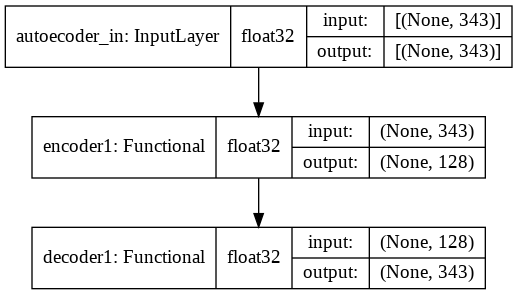

In [ ]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, show_dtype=True)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
lrr= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7, verbose=1)
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(
    train_X, 
    train_X,
    validation_split=0.2,
    epochs=100,
    verbose=1,
    callbacks=[es, lrr],
    batch_size=256
)

Epoch 1/100
1503/1503 [==============================] - 35s 22ms/step - loss: 0.1230 - val_loss: 0.0220
Epoch 2/100
1503/1503 [==============================] - 32s 21ms/step - loss: 0.0179 - val_loss: 0.0120
Epoch 3/100
1503/1503 [==============================] - 32s 21ms/step - loss: 0.0145 - val_loss: 0.0110
Epoch 4/100
1503/1503 [==============================] - 32s 22ms/step - loss: 0.0134 - val_loss: 0.0093
Epoch 5/100
1503/1503 [==============================] - 32s 21ms/step - loss: 0.0128 - val_loss: 0.0092
Epoch 6/100
1503/1503 [==============================] - 32s 21ms/step - loss: 0.0125 - val_loss: 0.0087
Epoch 7/100
1503/1503 [==============================] - 32s 21ms/step - loss: 0.0123 - val_loss: 0.0090
Epoch 8/100
1503/1503 [==============================] - 32s 21ms/step - loss: 0.0122 - val_loss: 0.0085
Epoch 9/100
1503/1503 [==============================] - 32s 21ms/step - loss: 0.0121 - val_loss: 0.0085
Epoch 10/100
1503/1503 [==============================]

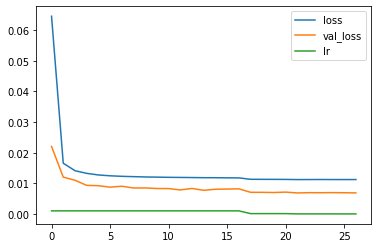

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
# now we do classification

In [ ]:
classidier_input = tf.keras.layers.Input(128, name='classifier_input')
classifier = tf.keras.layers.Dense(128, name='classifier_dence_1', activation='tanh')(classidier_input)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.layers.Dropout(0.2, name='classifier_drop_1')(classifier)
classifier = tf.keras.layers.Dense(32, name='classifier_dence_2', activation='tanh')(classifier)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.layers.Dense(8, name='classifier_dence_3', activation='tanh')(classifier)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier_out = tf.keras.layers.Dense(2, name='classifier_dence_4', activation='softmax')(classifier)

classify = tf.keras.models.Model(inputs=[classidier_input], outputs=[classifier_out], name='classifier1')
classify.summary()

Model: "classifier1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer [(None, 128)]             0         
_________________________________________________________________
classifier_dence_1 (Dense)   (None, 128)               16512     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
classifier_drop_1 (Dropout)  (None, 128)               0         
_________________________________________________________________
classifier_dence_2 (Dense)   (None, 32)                4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
classifier_dence_3 (Dense)   (None, 8)                 

In [ ]:
es1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
lrr1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-7, verbose=1)

y = pd.get_dummies(train_y.isFraud)
latent_vector = autoencoder.predict(train_X, verbose=1)

classify.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
history2 = classify.fit(
    latent_vector,
    y.values,
    validation_split=0.1,
    epochs=100,
    verbose=1,
    callbacks=[es1, lrr1]
)

15030/15030 [==============================] - 25s 2ms/step


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


preds = classify.predict(latent_vector,verbose=1)
preds = np.argmax(preds, axis=1)
score = metrics.accuracy_score(preds, train_y)

print(score)

15030/15030 [==============================] - 18s 1ms/step
0.9694721564941843


# 4

In [ ]:
# Now we do the second model
train_df = train_transaction_df.dropna(inplace=False)

tmp13 = pd.get_dummies(train_df[['ProductCD']])
train_df.drop('ProductCD', inplace=True, axis=1)
train_df = pd.concat([train_df, tmp13], axis=1)

train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


TransactionID  isFraud  ...  ProductCD_S  ProductCD_W
0             3151248        0  ...            0            1
1             3098966        0  ...            0            1
2             3058777        0  ...            0            1
3             3573874        0  ...            0            1
4             3355373        0  ...            0            1
...               ...      ...  ...          ...          ...
480933        3074733        0  ...            0            1
480934        3129378        0  ...            0            1
480935        3449554        0  ...            0            1
480936        3232234        0  ...            0            1
480937        3244944        0  ...            0            1

[480938 rows x 342 columns]

In [ ]:
import datetime

train_df.info()
train_df = train_df.astype(np.float32)
train_df.info()

hs = train_df[['TransactionDT']].values
mor = []
noon = []
nig = []
print(len(hs))
for hh in hs:
  h = datetime.datetime.utcfromtimestamp(hh).hour
  if 6 <= h and h <= 14:
    mor.append(1.0)
    noon.append(0)
    nig.append(0)
  elif 14 < h < 22:
    mor.append(0)
    noon.append(1.0)
    nig.append(0)
  else:
    mor.append(0)
    noon.append(0)
    nig.append(1.0)

print('mor: {}, noon: {}, night: {}'.format(len(mor), len(noon), len(nig)))
tmp = pd.DataFrame({
    'ismorning': mor,
    'isnoon': noon,
    'isnight': nig
})
print(len(tmp))
print(len(train_df))
train_df = pd.concat([train_df, tmp], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480938 entries, 0 to 480937
Columns: 342 entries, TransactionID to ProductCD_W
dtypes: float32(4), float64(184), int64(4), uint8(150)
memory usage: 766.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480938 entries, 0 to 480937
Columns: 342 entries, TransactionID to ProductCD_W
dtypes: float32(342)
memory usage: 627.4 MB
480938
mor: 480938, noon: 480938, night: 480938
480938
480938


In [ ]:
indexes = train_df.index[train_df.isFraud == 1]
fraud_df = train_df.iloc[indexes]
train_df.drop(train_df.index[[indexes]], inplace=True)

fraud_df.reset_index(drop=True)
train_df.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


TransactionID  isFraud  TransactionDT  ...  ismorning  isnoon  isnight
0           3151248.0      0.0      3494769.0  ...        1.0     0.0      0.0
1           3098966.0      0.0      2176790.0  ...        0.0     0.0      1.0
2           3058777.0      0.0      1613767.0  ...        0.0     1.0      0.0
3           3573874.0      0.0     15707027.0  ...        0.0     1.0      0.0
4           3355373.0      0.0      9153989.0  ...        0.0     0.0      1.0
...               ...      ...            ...  ...        ...     ...      ...
466251      3074733.0      0.0      1860869.0  ...        1.0     0.0      0.0
466252      3129378.0      0.0      2927113.0  ...        0.0     1.0      0.0
466253      3449554.0      0.0     11902362.0  ...        0.0     1.0      0.0
466254      3232234.0      0.0      5844524.0  ...        0.0     1.0      0.0
466255      3244944.0      0.0      6194623.0  ...        0.0     1.0      0.0

[466256 rows x 345 columns]

In [ ]:
train_df.drop('TransactionID', axis=1, inplace=True)
train_df.drop('isFraud', axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_df)
print(train_X)

[[2.16752084e-01 1.49352764e-03 1.08306985e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.32936400e-01 8.04674466e-04 3.02673182e-01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [9.71314611e-02 1.83951978e-03 5.13365910e-02 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 ...
 [7.51425366e-01 3.65558724e-03 7.51882725e-01 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [3.66182631e-01 3.37221800e-03 2.45645300e-01 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [3.88446860e-01 1.12314070e-02 5.45329118e-01 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]]


In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Add

autoencoder_input = Input(343, name = 'input_autoencoder')

out1_encoder = Dense(343, activation='relu',name = 'encoder_layer1')(autoencoder_input)
out2_encoder = Dense(256, activation='relu',name = 'encoder_layer2')(out1_encoder)
out2_encoder = BatchNormalization(name = 'encoder_layer3')(out2_encoder)
out3_encoder = Dense(128, activation='relu',name = 'encoder_layer4')(out2_encoder)

in3_decoder = Dense(128, activation='relu',name = 'decoder_layer1')(out3_encoder)
in3_decoder = Add()([in3_decoder,out3_encoder])
in4_decoder = Dense(256, activation='relu',name = 'decoder_layer2')(in3_decoder)
in4_decoder = Add()([in4_decoder,out2_encoder])
in5_decoder = Dense(343, activation='relu',name = 'decoder_layer3')(in4_decoder)
in5_decoder = Add()([in5_decoder,out1_encoder])


autoencoder = tf.keras.models.Model(inputs=[autoencoder_input], outputs=[in5_decoder], name='auto_encoder')

autoencoder.summary()

Model: "auto_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_autoencoder (InputLayer)  [(None, 343)]        0                                            
__________________________________________________________________________________________________
encoder_layer1 (Dense)          (None, 343)          117992      input_autoencoder[0][0]          
__________________________________________________________________________________________________
encoder_layer2 (Dense)          (None, 256)          88064       encoder_layer1[0][0]             
__________________________________________________________________________________________________
encoder_layer3 (BatchNormalizat (None, 256)          1024        encoder_layer2[0][0]             
_______________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(autoencoder, show_dtype=True, show_shapes=True)

In [ ]:
# autoencoder.load_weights('weights.hdf5')
# train_df = pd.read_csv('train_df')

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                   mode='auto',
                   verbose=1,
                   patience=7,
                   restore_best_weights=True)

lrr= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                       factor=0.1, 
                       patience=3, 
                       min_lr=1e-9,
                       verbose=1)

history = autoencoder.fit(
    train_X, 
    train_X,
    batch_size=256,
    validation_split = 0.2,
    epochs= 100,
    verbose=1,
    callbacks=[es , lrr])

Epoch 1/100
1458/1458 [==============================] - 29s 19ms/step - loss: 0.0311 - val_loss: 0.0118
Epoch 2/100
1458/1458 [==============================] - 27s 19ms/step - loss: 0.0078 - val_loss: 0.0109
Epoch 3/100
1458/1458 [==============================] - 28s 19ms/step - loss: 0.0066 - val_loss: 0.0093
Epoch 4/100
1458/1458 [==============================] - 28s 19ms/step - loss: 0.0057 - val_loss: 0.0076
Epoch 5/100
1458/1458 [==============================] - 28s 19ms/step - loss: 0.0051 - val_loss: 0.0082
Epoch 6/100
1458/1458 [==============================] - 28s 19ms/step - loss: 0.0049 - val_loss: 0.0109
Epoch 7/100
1458/1458 [==============================] - 28s 19ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 8/100
1458/1458 [==============================] - 28s 19ms/step - loss: 0.0046 - val_loss: 0.0131
Epoch 9/100
1458/1458 [==============================] - 28s 19ms/step - loss: 0.0047 - val_loss: 0.0066
Epoch 10/100
1458/1458 [==============================]

In [ ]:
autoencoder.save('model2.h5')
autoencoder.save_weights('weights.hdf5')
train_df.to_csv('train_df.csv')

In [ ]:
pd.DataFrame(history.history).plot()

now we got an auto encoder trained on not fraud data's. lets give  it fraud data and see its losses

In [ ]:
fraud_df.to_csv('fraud_df.csv')

In [ ]:
fraud_df.drop('isFraud', axis=1, inplace=True)
fraud_df.drop('TransactionID', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

fraud_X = scaler.fit_transform(fraud_df)
fraud_X

array([[0.86730956, 0.03038275, 0.48805953, ..., 0.        , 1.        ,
        0.        ],
       [0.08883994, 0.00394224, 0.27532303, ..., 0.        , 0.        ,
        1.        ],
       [0.84762799, 0.00371028, 0.52699585, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.51640985, 0.00248136, 0.16312875, ..., 0.        , 0.        ,
        1.        ],
       [0.59266638, 0.00329936, 0.39859252, ..., 0.        , 1.        ,
        0.        ],
       [0.10526646, 0.003403  , 0.24953853, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
from tqdm import tqdm

mae = tf.keras.losses.MeanAbsoluteError()
fraud_losses = []
preds = autoencoder.predict(fraud_X, verbose=1)
with tqdm(total=preds.shape[0], unit='calc_error') as pbar:
  for index, record in enumerate(preds):
    fraud_losses.append(mae(fraud_X[index], record).numpy())
    pbar.update(1)


459/459 [==============================] - 1s 2ms/step


100%|██████████| 14682/14682 [00:10<00:00, 1456.04calc_error/s]


In [ ]:
train_losses = []
preds = autoencoder.predict(train_X, verbose=1)
with tqdm(total=preds.shape[0], unit='calc_error') as pbar:
  for index, record in enumerate(preds):
    train_losses.append(mae(train_X[index], record).numpy())
    pbar.update(1)

14571/14571 [==============================] - 23s 2ms/step


100%|██████████| 466256/466256 [05:04<00:00, 1532.40calc_error/s]


In [ ]:
df = pd.DataFrame.from_dict({
    'fraud': fraud_losses,
    'train': train_losses
}, orient='index')

df = df.transpose()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

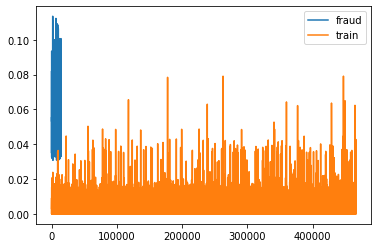

In [ ]:
df.plot(kind='box')
plt.figure()
df.plot()

## choose loss

now lets choose a good value for loss (loss more than some amount means fraud else not fraud)  
we chose one of the blow:
1. minimum of fraud losses
2. Q1 of fraud losses
3. max of train losses
4. min of fraud losses after deleting 
5. loss value that makes max accuracy  

we calculate accuracy for each one.

In [ ]:
train_losses.sort()
fraud_losses.sort()
train_losses = np.array(train_losses)
fraud_losses = np.array(fraud_losses)

In [ ]:
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def calculate_accuracy_with_limit(fraud_np, train_np, limit):
  """
    has 3 return
      first: accuracy of correct prediction
      second: percent of correct fraud prediction
      third: percent of correct train prediction
  """
  f1 = find_nearest_index(fraud_np, limit)
  f2 = fraud_np.shape[0] - f1
  t1 = find_nearest_index(train_np, limit)
  t2 = train_np.shape[0] - t1
  su = f1 + f2 + t1 + t2
  return ((f2 + t1) / su * 100), ((f2 / (f1 + f2)) * 100), ((t1 / (t1 + t2)) * 100)


In [ ]:
limit = fraud_losses[0]
ac1, ac2, ac3 = calculate_accuracy_with_limit(fraud_losses, train_losses, limit)
print('method1')
print('accuracy if we set loss limit to {} is {:.4f}%.'.format(limit, ac1))
print('{:.4f}% of frauds were predicted correct and {:.4f}% of not fraud data has been predicted correctly'.format(ac2, ac3))
print('*' * 30)

limit = fraud_losses[int(fraud_losses.shape[0] / 4)]
ac1, ac2, ac3 = calculate_accuracy_with_limit(fraud_losses, train_losses, limit)
print('method2')
print('accuracy if we set loss limit to {} is {:.4f}%.'.format(limit, ac1))
print('{:.4f}% of frauds were predicted correct and {:.4f}% of not fraud data has been predicted correctly'.format(ac2, ac3))
print('*' * 30)

limit = train_losses[-1]
ac1, ac2, ac3 = calculate_accuracy_with_limit(fraud_losses, train_losses, limit)
print('method3')
print('accuracy if we set loss limit to {} is {:.4f}%.'.format(limit, ac1))
print('{:.4f}% of frauds were predicted correct and {:.4f}% of not fraud data has been predicted correctly'.format(ac2, ac3))
print('*' * 30)

q1 = fraud_losses[int(fraud_losses.shape[0] / 4)]
q3 = fraud_losses[int(fraud_losses.shape[0] / 4 * 3)]
r = q3 - q1
min_not_outlier_loss = q1 - 1.5 * r 
i = find_nearest_index(fraud_losses, min_not_outlier_loss)
limit = fraud_losses[i]
ac1, ac2, ac3 = calculate_accuracy_with_limit(fraud_losses, train_losses, limit)
print('method4')
print('accuracy if we set loss limit to {} is {:.4f}%.'.format(limit, ac1))
print('{:.4f}% of frauds were predicted correct and {:.4f}% of not fraud data has been predicted correctly'.format(ac2, ac3))
print('*' * 30)

best_loss = 1
best_ac = 0
for i in fraud_losses:
  a, _, _ = calculate_accuracy_with_limit(fraud_losses, train_losses, i)
  if best_ac < a:
    best_ac = a
    best_loss = i
limit = best_loss
ac1, ac2, ac3 = calculate_accuracy_with_limit(fraud_losses, train_losses, limit)
print('method5')
print('accuracy if we set loss limit to {} is {:.4f}%.'.format(limit, ac1))
print('{:.4f}% of frauds were predicted correct and {:.4f}% of not fraud data has been predicted correctly'.format(ac2, ac3))

method1
accuracy if we set loss limit to 0.030795792117714882 is 99.9719%.
100.0000% of frauds were predicted correct and 99.9710% of not fraud data has been predicted correctly
******************************
method2
accuracy if we set loss limit to 0.04982190951704979 is 99.2344%.
75.0034% of frauds were predicted correct and 99.9974% of not fraud data has been predicted correctly
******************************
method3
accuracy if we set loss limit to 0.07911006361246109 is 96.9898%.
1.4031% of frauds were predicted correct and 99.9998% of not fraud data has been predicted correctly
******************************
method4
accuracy if we set loss limit to 0.030795792117714882 is 99.9719%.
100.0000% of frauds were predicted correct and 99.9710% of not fraud data has been predicted correctly
******************************
method5
accuracy if we set loss limit to 0.032493650913238525 is 99.9730%.
99.9591% of frauds were predicted correct and 99.9734% of not fraud data has been predicted co

# add identity feature

In [ ]:
fraud_df = pd.read_csv('drive/MyDrive/fraud_df.csv')
train_df = pd.read_csv('drive/MyDrive/train_df.csv')

In [ ]:
train_identity_df = pd.read_csv('Proj3/train_identity.csv')

it's Done.  
now we add identity as a feature to transaction. this feature has a value that being negetive means that this is more like fraud and positive values means its more like a not fraud transaction.  
being 0 means identity have no such effect or we could say that it means identity features can't help that much about being fraud or not. with this we can put null values to 0.  


In [ ]:
train_identity_df

TransactionID  id_01  ...  DeviceType                          DeviceInfo
0             2987004    0.0  ...      mobile       SAMSUNG SM-G892A Build/NRD90M
1             2987008   -5.0  ...      mobile                          iOS Device
2             2987010   -5.0  ...     desktop                             Windows
3             2987011   -5.0  ...     desktop                                 NaN
4             2987016    0.0  ...     desktop                               MacOS
...               ...    ...  ...         ...                                 ...
144228        3577521  -15.0  ...      mobile             F3111 Build/33.3.A.1.97
144229        3577526   -5.0  ...      mobile                 A574BL Build/NMF26F
144230        3577529  -20.0  ...      mobile  Moto E (4) Plus Build/NMA26.42-152
144231        3577531   -5.0  ...     desktop                               MacOS
144232        3577534  -45.0  ...      mobile         RNE-L03 Build/HUAWEIRNE-L03

[144233 rows x 41 columns]

In [ ]:
col_to_delete1 = []
for i in train_identity_df.columns.to_list():
  nulls = train_identity_df[[i]].isnull().sum()[0]
  all = len(train_identity_df[[i]])
  print('column {}\t have {}\t null values which is {:.2f}%\t out of all'.format(i, nulls, nulls / all * 100), end=' ')
  print('this column has {}\t unique values'.format(len(train_identity_df[[i]].drop_duplicates())), 'column type is', train_identity_df[[i]].dtypes[0])
  if nulls / all * 100 > 40 and train_identity_df[[i]].dtypes[0] != np.object:
    col_to_delete1.append(i)

column TransactionID	 have 0	 null values which is 0.00%	 out of all this column has 144233	 unique values column type is int64
column id_01	 have 0	 null values which is 0.00%	 out of all this column has 77	 unique values column type is float64
column id_02	 have 3361	 null values which is 2.33%	 out of all this column has 115656	 unique values column type is float64
column id_03	 have 77909	 null values which is 54.02%	 out of all this column has 25	 unique values column type is float64
column id_04	 have 77909	 null values which is 54.02%	 out of all this column has 16	 unique values column type is float64
column id_05	 have 7368	 null values which is 5.11%	 out of all this column has 94	 unique values column type is float64
column id_06	 have 7368	 null values which is 5.11%	 out of all this column has 102	 unique values column type is float64
column id_07	 have 139078	 null values which is 96.43%	 out of all this column has 85	 unique values column type is float64
column id_08	 ha

In [ ]:
col_to_delete1

['id_03',
 'id_04',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_14',
 'id_18',
 'id_21',
 'id_22',
 'id_24',
 'id_25',
 'id_26',
 'id_32']

In [ ]:
train_identity_df.drop(col_to_delete1, axis=1, inplace=True)

In [ ]:
train_identity_df

TransactionID  id_01  ...  DeviceType                          DeviceInfo
0             2987004    0.0  ...      mobile       SAMSUNG SM-G892A Build/NRD90M
1             2987008   -5.0  ...      mobile                          iOS Device
2             2987010   -5.0  ...     desktop                             Windows
3             2987011   -5.0  ...     desktop                                 NaN
4             2987016    0.0  ...     desktop                               MacOS
...               ...    ...  ...         ...                                 ...
144228        3577521  -15.0  ...      mobile             F3111 Build/33.3.A.1.97
144229        3577526   -5.0  ...      mobile                 A574BL Build/NMF26F
144230        3577529  -20.0  ...      mobile  Moto E (4) Plus Build/NMA26.42-152
144231        3577531   -5.0  ...     desktop                               MacOS
144232        3577534  -45.0  ...      mobile         RNE-L03 Build/HUAWEIRNE-L03

[144233 rows x 27 columns]

In [ ]:
col_to_onehot = []
for i in train_identity_df.columns.to_list():
  nulls = train_identity_df[[i]].isnull().sum()[0]
  all = len(train_identity_df[[i]])
  if train_identity_df[[i]].dtypes[0] == np.object and len(train_identity_df[[i]].drop_duplicates()) < 10:
    print('column {}\t have {}\t null values which is {:.2f}%\t out of all'.format(i, nulls, nulls / all * 100), end=' ')
    print('this column has {}\t unique values'.format(len(train_identity_df[[i]].drop_duplicates())), 'column type is', train_identity_df[[i]].dtypes[0])
    col_to_onehot.append(i)

col_to_onehot

column id_12	 have 0	 null values which is 0.00%	 out of all this column has 2	 unique values column type is object
column id_15	 have 3248	 null values which is 2.25%	 out of all this column has 4	 unique values column type is object
column id_16	 have 14893	 null values which is 10.33%	 out of all this column has 3	 unique values column type is object
column id_23	 have 139064	 null values which is 96.42%	 out of all this column has 4	 unique values column type is object
column id_27	 have 139064	 null values which is 96.42%	 out of all this column has 3	 unique values column type is object
column id_28	 have 3255	 null values which is 2.26%	 out of all this column has 3	 unique values column type is object
column id_29	 have 3255	 null values which is 2.26%	 out of all this column has 3	 unique values column type is object
column id_34	 have 66428	 null values which is 46.06%	 out of all this column has 5	 unique values column type is object
column id_35	 have 3248	 null values whic

['id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType']

In [ ]:
for i in col_to_onehot:
  tmp = pd.get_dummies(train_identity_df[[i]])
  train_identity_df.drop(i, axis=1, inplace=True)
  train_identity_df = pd.concat([train_identity_df, tmp], axis=1)

In [ ]:
train_identity_df

TransactionID  id_01  ...  DeviceType_desktop  DeviceType_mobile
0             2987004    0.0  ...                   0                  1
1             2987008   -5.0  ...                   0                  1
2             2987010   -5.0  ...                   1                  0
3             2987011   -5.0  ...                   1                  0
4             2987016    0.0  ...                   1                  0
...               ...    ...  ...                 ...                ...
144228        3577521  -15.0  ...                   0                  1
144229        3577526   -5.0  ...                   0                  1
144230        3577529  -20.0  ...                   0                  1
144231        3577531   -5.0  ...                   1                  0
144232        3577534  -45.0  ...                   0                  1

[144233 rows x 44 columns]

In [ ]:
for i in train_identity_df.columns.to_list():
  nulls = train_identity_df[[i]].isnull().sum()[0]
  all = len(train_identity_df[[i]])
  print('column {}\t have {}\t null values which is {:.2f}%\t out of all'.format(i, nulls, nulls / all * 100), end=' ')
  print('this column has {}\t unique values'.format(len(train_identity_df[[i]].drop_duplicates())), 'column type is', train_identity_df[[i]].dtypes[0])


column TransactionID	 have 0	 null values which is 0.00%	 out of all this column has 144233	 unique values column type is int64
column id_01	 have 0	 null values which is 0.00%	 out of all this column has 77	 unique values column type is float64
column id_02	 have 3361	 null values which is 2.33%	 out of all this column has 115656	 unique values column type is float64
column id_05	 have 7368	 null values which is 5.11%	 out of all this column has 94	 unique values column type is float64
column id_06	 have 7368	 null values which is 5.11%	 out of all this column has 102	 unique values column type is float64
column id_11	 have 3255	 null values which is 2.26%	 out of all this column has 366	 unique values column type is float64
column id_13	 have 16913	 null values which is 11.73%	 out of all this column has 55	 unique values column type is float64
column id_17	 have 4864	 null values which is 3.37%	 out of all this column has 105	 unique values column type is float64
column id_19	 have 

In [ ]:
train_identity_df.id_30.unique()

array(['Android 7.0', 'iOS 11.1.2', nan, 'Mac OS X 10_11_6', 'Windows 10',
       'Android', 'Linux', 'iOS 11.0.3', 'Mac OS X 10_7_5',
       'Mac OS X 10_12_6', 'Mac OS X 10_13_1', 'iOS 11.1.0',
       'Mac OS X 10_9_5', 'Windows 7', 'Windows 8.1', 'Mac', 'iOS 10.3.3',
       'Mac OS X 10.12', 'Mac OS X 10_10_5', 'Mac OS X 10_11_5',
       'iOS 9.3.5', 'Android 5.1.1', 'Android 7.1.1', 'Android 6.0',
       'iOS 10.3.1', 'Mac OS X 10.9', 'iOS 11.1.1', 'Windows Vista',
       'iOS 10.3.2', 'iOS 11.0.2', 'Mac OS X 10.11', 'Android 8.0.0',
       'iOS 10.2.0', 'iOS 10.2.1', 'iOS 11.0.0', 'Mac OS X 10.10',
       'Mac OS X 10_12_3', 'Mac OS X 10_12', 'Android 6.0.1', 'iOS',
       'Mac OS X 10.13', 'Mac OS X 10_12_5', 'Mac OS X 10_8_5',
       'iOS 11.0.1', 'iOS 10.0.2', 'Android 5.0.2', 'Windows XP',
       'iOS 11.2.0', 'Mac OS X 10.6', 'Windows 8', 'Mac OS X 10_6_8',
       'Mac OS X 10_11_4', 'Mac OS X 10_12_1', 'iOS 10.1.1',
       'Mac OS X 10_11_3', 'Mac OS X 10_12_4', 'Mac OS X 10

In [ ]:
train_identity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 44 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   TransactionID               144233 non-null  int64  
 1   id_01                       144233 non-null  float64
 2   id_02                       140872 non-null  float64
 3   id_05                       136865 non-null  float64
 4   id_06                       136865 non-null  float64
 5   id_11                       140978 non-null  float64
 6   id_13                       127320 non-null  float64
 7   id_17                       139369 non-null  float64
 8   id_19                       139318 non-null  float64
 9   id_20                       139261 non-null  float64
 10  id_30                       77565 non-null   object 
 11  id_31                       140282 non-null  object 
 12  id_33                       73289 non-null   object 
 13  DeviceInfo    

In [ ]:
labels = ['Android', 'iOS', 'Mac', 'Windows', 'Linux', 'func', 'other']

In [ ]:
tmp_arr = []
for i in train_identity_df.id_30.values:
  if i is np.nan:
    tmp_arr.append(np.nan)
    continue
  if 'Android' in i:
    tmp_arr.append('Android')
  elif 'iOS' in i:
    tmp_arr.append('iOS')
  elif 'Mac' in i:
    tmp_arr.append('Mac')
  elif 'Windows' in i:
    tmp_arr.append('Windows')
  elif 'Linux' in i:
    tmp_arr.append('Linux')
  elif 'func' in i:
    tmp_arr.append('func')
  elif 'other' in i:
    tmp_arr.append('other')

In [ ]:
len(tmp_arr) == len(train_identity_df)

True

In [ ]:
tmp = pd.get_dummies(pd.DataFrame({'id_30': tmp_arr}))

train_identity_df.drop('id_30', inplace=True, axis=1)

train_identity_df = pd.concat([train_identity_df, tmp], axis=1)

In [ ]:
train_identity_df

TransactionID  id_01     id_02  ...  id_30_func  id_30_iOS  id_30_other
0             2987004    0.0   70787.0  ...           0          0            0
1             2987008   -5.0   98945.0  ...           0          1            0
2             2987010   -5.0  191631.0  ...           0          0            0
3             2987011   -5.0  221832.0  ...           0          0            0
4             2987016    0.0    7460.0  ...           0          0            0
...               ...    ...       ...  ...         ...        ...          ...
144228        3577521  -15.0  145955.0  ...           0          0            0
144229        3577526   -5.0  172059.0  ...           0          0            0
144230        3577529  -20.0  632381.0  ...           0          0            0
144231        3577531   -5.0   55528.0  ...           0          0            0
144232        3577534  -45.0  339406.0  ...           0          0            0

[144233 rows x 50 columns]

In [ ]:
import re

print(train_identity_df.id_31.unique())

print('*' * 20)

new_arr1 = []
for i in train_identity_df.id_31.unique():
  if i is np.nan:
    continue
  breaked = re.split(r'[0-9]+\.?[0-9]*', i)
  st = ''
  for j in breaked:
    if j.strip() == '':
      continue
    if j.replace(' ', '').replace('/', '').replace('-', '').isalpha():
      st += j.strip()
    else:
      print(j)
      raise  Exception()
  new_arr1.append(st)
  

['samsung browser 6.2' 'mobile safari 11.0' 'chrome 62.0' nan
 'chrome 62.0 for android' 'edge 15.0' 'mobile safari generic'
 'chrome 49.0' 'chrome 61.0' 'edge 16.0' 'safari generic' 'edge 14.0'
 'chrome 56.0 for android' 'firefox 57.0' 'chrome 54.0 for android'
 'mobile safari uiwebview' 'chrome' 'chrome 62.0 for ios' 'firefox'
 'chrome 60.0 for android' 'mobile safari 10.0' 'chrome 61.0 for android'
 'ie 11.0 for desktop' 'ie 11.0 for tablet' 'mobile safari 9.0'
 'chrome generic' 'other' 'chrome 59.0 for android' 'firefox 56.0'
 'android webview 4.0' 'chrome 55.0' 'opera 49.0' 'ie'
 'chrome 55.0 for android' 'firefox 52.0' 'chrome 57.0 for android'
 'chrome 56.0' 'chrome 46.0 for android' 'chrome 58.0' 'firefox 48.0'
 'chrome 59.0' 'samsung browser 4.0' 'edge 13.0' 'chrome 53.0 for android'
 'chrome 58.0 for android' 'chrome 60.0' 'mobile safari 8.0'
 'firefox generic' 'Generic/Android 7.0' 'mobile' 'Samsung/SM-G532M'
 'chrome 50.0 for android' 'chrome 51.0 for android' 'chrome 63.0'

In [ ]:
new_arr1 = list(set(new_arr1))
len(set(new_arr1))

57

In [ ]:
new_arr1

['firefox generic',
 'Lanix/Ilium',
 'chromefor ios',
 'iefor desktop',
 'opera',
 'samsung browser',
 'Nokia/Lumia',
 'chromium',
 'android',
 'safari generic',
 'mobile safari',
 'facebook',
 'firefox mobile',
 'mobile',
 'google search application',
 'chrome generic for android',
 'Samsung/SCH',
 'samsung',
 'Microsoft/Windows',
 'seamonkey',
 'android webview',
 'chromefor android',
 'line',
 'google',
 'maxthon',
 'Samsung/SM-GH',
 'iron',
 'mobile safari uiwebview',
 'Cherry',
 'Mozilla/Firefox',
 'firefox',
 'other',
 'ie',
 'Generic/Android',
 'aol',
 'chrome',
 'Samsung/SM-GM',
 'cyberfox',
 'samsung browser generic',
 'chrome generic',
 'LG/K-',
 'android browser',
 'icedragon',
 'MTel/M',
 'iefor tablet',
 'edge',
 'comodo',
 'opera generic',
 'ZTE/Blade',
 'waterfox',
 'BLU/Dash',
 'palemoon',
 'Inco/Minion',
 'puffin',
 'safari',
 'silk',
 'mobile safari generic']

we want to label encode data and give the one with more fraud more value so first we add fraud column then we do it.

In [ ]:
from tqdm import tqdm

identity_ids = train_identity_df.TransactionID.to_numpy()
is_fraud = []
with tqdm(total=len(identity_ids), unit='record') as pbar:
  for id in identity_ids:
    is_fraud.append(train_transaction_df[train_transaction_df.TransactionID == id].isFraud.values[0])
    pbar.update(1)
  
tmp = pd.DataFrame({'isFraud': is_fraud})
train_identity_df = pd.concat([train_identity_df, tmp], axis=1)

100%|██████████| 144233/144233 [04:21<00:00, 551.87record/s]


In [ ]:
id_31_dict = {}

su = 0
for i in train_identity_df.id_31.unique():
  # tmp = train_identity_df['id_31'].str.contains(i, regex=False)
  tmp = train_identity_df[train_identity_df.id_31 == i]
  tmp1 = tmp.isFraud.sum()
  id_31_dict[i] = tmp1
  print('from {} there is {} row and {} number of them is fraud which is {:.2f}% of them'.format(i, len(tmp), tmp1, tmp1 / len(tmp) * 100))
  su += len(tmp)
  
print('number of all checked is {} that must be lesser than {} because of nulls'.format(su, len(train_identity_df)))
id_31_dict


from samsung browser 6.2 there is 1061 row and 75 number of them is fraud which is 7.07% of them
from mobile safari 11.0 there is 13423 row and 842 number of them is fraud which is 6.27% of them
from chrome 62.0 there is 7182 row and 299 number of them is fraud which is 4.16% of them
from nan there is 0 row and 0 number of them is fraud which is nan% of them
from chrome 62.0 for android there is 2097 row and 161 number of them is fraud which is 7.68% of them
from edge 15.0 there is 1600 row and 61 number of them is fraud which is 3.81% of them
from mobile safari generic there is 11474 row and 1146 number of them is fraud which is 9.99% of them
from chrome 49.0 there is 719 row and 40 number of them is fraud which is 5.56% of them
from chrome 61.0 there is 642 row and 39 number of them is fraud which is 6.07% of them
from edge 16.0 there is 4188 row and 115 number of them is fraud which is 2.75% of them
from safari generic there is 8195 row and 205 number of them is fraud which is 2.50%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


from mobile safari 10.0 there is 2779 row and 128 number of them is fraud which is 4.61% of them
from chrome 61.0 for android there is 538 row and 72 number of them is fraud which is 13.38% of them
from ie 11.0 for desktop there is 9030 row and 175 number of them is fraud which is 1.94% of them
from ie 11.0 for tablet there is 647 row and 1 number of them is fraud which is 0.15% of them
from mobile safari 9.0 there is 541 row and 16 number of them is fraud which is 2.96% of them
from chrome generic there is 4778 row and 803 number of them is fraud which is 16.81% of them
from other there is 312 row and 61 number of them is fraud which is 19.55% of them
from chrome 59.0 for android there is 227 row and 13 number of them is fraud which is 5.73% of them
from firefox 56.0 there is 126 row and 2 number of them is fraud which is 1.59% of them
from android webview 4.0 there is 285 row and 69 number of them is fraud which is 24.21% of them
from chrome 55.0 there is 64 row and 15 number of them

{'BLU/Dash': 0,
 'Cherry': 0,
 'Generic/Android': 7,
 'Generic/Android 7.0': 16,
 'Inco/Minion': 0,
 'LG/K-200': 0,
 'Lanix/Ilium': 2,
 'M4Tel/M4': 0,
 'Microsoft/Windows': 0,
 'Mozilla/Firefox': 5,
 'Nokia/Lumia': 0,
 'Samsung/SCH': 0,
 'Samsung/SM-G531H': 1,
 'Samsung/SM-G532M': 17,
 'ZTE/Blade': 2,
 'android': 0,
 'android browser 4.0': 15,
 'android webview 4.0': 69,
 'aol': 0,
 'chrome': 34,
 'chrome 43.0 for android': 19,
 'chrome 46.0 for android': 16,
 'chrome 49.0': 40,
 'chrome 49.0 for android': 29,
 'chrome 50.0 for android': 38,
 'chrome 51.0': 2,
 'chrome 51.0 for android': 5,
 'chrome 52.0 for android': 58,
 'chrome 53.0 for android': 0,
 'chrome 54.0 for android': 12,
 'chrome 55.0': 15,
 'chrome 55.0 for android': 28,
 'chrome 56.0': 11,
 'chrome 56.0 for android': 44,
 'chrome 57.0': 0,
 'chrome 57.0 for android': 5,
 'chrome 58.0': 51,
 'chrome 58.0 for android': 50,
 'chrome 59.0': 4,
 'chrome 59.0 for android': 13,
 'chrome 60.0': 37,
 'chrome 60.0 for android': 22

In [ ]:
new_dict = {}

for key, value in id_31_dict.items():
  if key is np.nan:
    continue
  breaked = re.split(r'[0-9]+\.?[0-9]*', key)
  st = ''
  for j in breaked:
    if j.strip() == '':
      continue
    if j.replace(' ', '').replace('/', '').replace('-', '').isalpha():
      st += j.strip()
  tmp = new_dict.get(st, 0)
  new_dict[st] = tmp + value

new_dict

{'BLU/Dash': 0,
 'Cherry': 0,
 'Generic/Android': 23,
 'Inco/Minion': 0,
 'LG/K-': 0,
 'Lanix/Ilium': 2,
 'MTel/M': 0,
 'Microsoft/Windows': 0,
 'Mozilla/Firefox': 5,
 'Nokia/Lumia': 0,
 'Samsung/SCH': 0,
 'Samsung/SM-GH': 1,
 'Samsung/SM-GM': 17,
 'ZTE/Blade': 2,
 'android': 0,
 'android browser': 15,
 'android webview': 69,
 'aol': 0,
 'chrome': 3736,
 'chrome generic': 803,
 'chrome generic for android': 127,
 'chromefor android': 2573,
 'chromefor ios': 59,
 'chromium': 0,
 'comodo': 4,
 'cyberfox': 0,
 'edge': 225,
 'facebook': 0,
 'firefox': 533,
 'firefox generic': 15,
 'firefox mobile': 0,
 'google': 3,
 'google search application': 0,
 'icedragon': 5,
 'ie': 10,
 'iefor desktop': 175,
 'iefor tablet': 1,
 'iron': 0,
 'line': 0,
 'maxthon': 0,
 'mobile': 3,
 'mobile safari': 987,
 'mobile safari generic': 1146,
 'mobile safari uiwebview': 7,
 'opera': 107,
 'opera generic': 35,
 'other': 61,
 'palemoon': 0,
 'puffin': 0,
 'safari': 39,
 'safari generic': 205,
 'samsung': 2,
 's

In [ ]:
import operator

id_31_labels = {}
count = 1
for i in sorted(new_dict.items(), key=operator.itemgetter(1)):
  id_31_labels[i[0]] = count
  count += 1

In [ ]:
id_31_labels

{'BLU/Dash': 14,
 'Cherry': 19,
 'Generic/Android': 39,
 'Inco/Minion': 18,
 'LG/K-': 12,
 'Lanix/Ilium': 28,
 'MTel/M': 16,
 'Microsoft/Windows': 7,
 'Mozilla/Firefox': 32,
 'Nokia/Lumia': 5,
 'Samsung/SCH': 2,
 'Samsung/SM-GH': 25,
 'Samsung/SM-GM': 38,
 'ZTE/Blade': 27,
 'android': 20,
 'android browser': 37,
 'android webview': 45,
 'aol': 1,
 'chrome': 57,
 'chrome generic': 53,
 'chrome generic for android': 47,
 'chromefor android': 56,
 'chromefor ios': 43,
 'chromium': 17,
 'comodo': 31,
 'cyberfox': 8,
 'edge': 51,
 'facebook': 22,
 'firefox': 52,
 'firefox generic': 36,
 'firefox mobile': 23,
 'google': 30,
 'google search application': 21,
 'icedragon': 33,
 'ie': 35,
 'iefor desktop': 49,
 'iefor tablet': 24,
 'iron': 13,
 'line': 11,
 'maxthon': 10,
 'mobile': 29,
 'mobile safari': 54,
 'mobile safari generic': 55,
 'mobile safari uiwebview': 34,
 'opera': 46,
 'opera generic': 41,
 'other': 44,
 'palemoon': 9,
 'puffin': 6,
 'safari': 42,
 'safari generic': 50,
 'samsung

In [ ]:
tmp_arr = []
for i in train_identity_df.id_31.to_numpy():
  if i is np.nan:
    tmp_arr.append(0)
    continue
  breaked = re.split(r'[0-9]+\.?[0-9]*', i)
  st = ''
  for j in breaked:
    if j.strip() == '':
      continue
    if j.replace(' ', '').replace('/', '').replace('-', '').isalpha():
      st += j.strip()
  tmp_arr.append(id_31_labels[st])

assert len(tmp_arr) == len(train_identity_df)

train_identity_df.drop('id_31', axis=1, inplace=True)

tmp = pd.DataFrame({'id_31': tmp_arr})
train_identity_df = pd.concat([train_identity_df, tmp], axis=1)

we delete id_33 and add a featurre wheter it have the feature or it was null

In [ ]:
tmp3 = train_identity_df[['id_33']]
tmp4 = tmp3.notnull().astype(np.float32)

train_identity_df.drop('id_33', inplace=True, axis=1)

train_identity_df = pd.concat([train_identity_df, tmp4], axis=1)

now we do the same with DEvice Info

In [ ]:
tmp3 = train_identity_df[['DeviceInfo']]
tmp4 = tmp3.notnull().astype(np.float32)

train_identity_df.drop('DeviceInfo', inplace=True, axis=1)

train_identity_df = pd.concat([train_identity_df, tmp4], axis=1)

In [ ]:
train_identity_df

TransactionID  id_01     id_02  ...  id_31  id_33  DeviceInfo
0             2987004    0.0   70787.0  ...     48    1.0         1.0
1             2987008   -5.0   98945.0  ...     54    1.0         1.0
2             2987010   -5.0  191631.0  ...     57    0.0         1.0
3             2987011   -5.0  221832.0  ...     57    0.0         0.0
4             2987016    0.0    7460.0  ...     57    1.0         1.0
...               ...    ...       ...  ...    ...    ...         ...
144228        3577521  -15.0  145955.0  ...     56    0.0         1.0
144229        3577526   -5.0  172059.0  ...     56    1.0         1.0
144230        3577529  -20.0  632381.0  ...     56    0.0         1.0
144231        3577531   -5.0   55528.0  ...     57    1.0         1.0
144232        3577534  -45.0  339406.0  ...     56    0.0         1.0

[144233 rows x 51 columns]

In [ ]:
for i in train_identity_df.columns.to_list():
  nulls = train_identity_df[[i]].isnull().sum()[0]
  all = len(train_identity_df[[i]])
  print('column {}\t have {}\t null values which is {:.2f}%\t out of all'.format(i, nulls, nulls / all * 100), end=' ')
  print('this column has {}\t unique values'.format(len(train_identity_df[[i]].drop_duplicates())), 'column type is', train_identity_df[[i]].dtypes[0])


column TransactionID	 have 0	 null values which is 0.00%	 out of all this column has 144233	 unique values column type is int64
column id_01	 have 0	 null values which is 0.00%	 out of all this column has 77	 unique values column type is float64
column id_02	 have 3361	 null values which is 2.33%	 out of all this column has 115656	 unique values column type is float64
column id_05	 have 7368	 null values which is 5.11%	 out of all this column has 94	 unique values column type is float64
column id_06	 have 7368	 null values which is 5.11%	 out of all this column has 102	 unique values column type is float64
column id_11	 have 3255	 null values which is 2.26%	 out of all this column has 366	 unique values column type is float64
column id_13	 have 16913	 null values which is 11.73%	 out of all this column has 55	 unique values column type is float64
column id_17	 have 4864	 null values which is 3.37%	 out of all this column has 105	 unique values column type is float64
column id_19	 have 

In [ ]:
print_distribution(train_identity_df) 
tmp = train_identity_df.dropna(inplace=False)
print('*' * 100)
print_distribution(tmp)

In [ ]:
train_identity_df.dropna(inplace=True)

now we use a simple linear model. we solve Aw=b where A is out train feature and b is the vector shows is fraud or not.  
before that we scale our is fraud column to -1 to 1. then we train our simple model were is the matrix of w.  
then we add feature of Aw as a feature to train_transaction_df and train our previous model.  
more detail on report.  
actually for learnin process which is finding the matrix w we do as  
* $$w = (A^TA)^{-1}A^TB$$

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler((-1, 1))

train_identity_df[['isFraud']] = mms.fit_transform(train_identity_df[['isFraud']])

In [ ]:
train_identity_df

TransactionID  id_01     id_02  ...  id_31  id_33  DeviceInfo
1             2987008   -5.0   98945.0  ...     54    1.0         1.0
2             2987010   -5.0  191631.0  ...     57    0.0         1.0
3             2987011   -5.0  221832.0  ...     57    0.0         0.0
5             2987017   -5.0   61141.0  ...     57    1.0         1.0
8             2987040  -10.0  116098.0  ...     57    0.0         1.0
...               ...    ...       ...  ...    ...    ...         ...
144228        3577521  -15.0  145955.0  ...     56    0.0         1.0
144229        3577526   -5.0  172059.0  ...     56    1.0         1.0
144230        3577529  -20.0  632381.0  ...     56    0.0         1.0
144231        3577531   -5.0   55528.0  ...     57    1.0         1.0
144232        3577534  -45.0  339406.0  ...     56    0.0         1.0

[120072 rows x 51 columns]

In [ ]:
train_identity_df = train_identity_df.astype(np.float64)
train_identity_df.shape

(120072, 51)

In [ ]:
identity_ids = train_identity_df.TransactionID
identity_isFrauds = train_identity_df.isFraud

train_identity_df.drop('TransactionID', axis=1, inplace=True)
train_identity_df.drop('isFraud', axis=1, inplace=True)

In [ ]:
# Aw=b so we calculate w
W = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(train_identity_df.values), train_identity_df.values)), np.transpose(train_identity_df.values)), identity_isFrauds.values)
W

array([ 9.34447072e-01,  1.32467529e-05,  2.13870433e+00,  3.61009012e-01,
       -3.14585086e+00, -2.37026307e-01, -1.13040733e-01, -6.38349584e-03,
        3.63106759e-03, -7.52352552e+14, -7.52352552e+14, -1.71805508e+14,
       -1.71805508e+14,  6.38078132e+14,  8.09883640e+14,  8.09883640e+14,
       -1.36107260e+15, -1.36107260e+15, -1.36107260e+15,  1.36107260e+15,
        1.36107260e+15,  2.07274456e+13,  2.07274456e+13, -2.95834362e+14,
       -2.95834362e+14, -6.76838580e+00,  4.13737145e+00,  4.55014887e+00,
        4.27870323e+00,  1.92204035e+14,  1.92204035e+14, -1.35610816e+14,
       -1.35610816e+14,  3.32788118e+14,  3.32788118e+14,  8.26896397e+01,
        8.38419440e+01, -7.19190312e-02, -2.27846132e-02, -4.80667535e-01,
       -3.94938782e-01, -5.34275919e-01, -5.22463972e-01, -5.78123678e-01,
       -4.77520650e-01,  7.66653152e-01,  3.10229359e-04,  5.32350731e-02,
       -4.33818294e-02])

In [ ]:
new_feature = np.matmul(train_identity_df.values, W)
print(new_feature.shape)
new_feature

(120072,)


array([ -7.69425565,   3.80682619,  -2.77479198, ..., -22.4237936 ,
        -6.57865863, -90.4237936 ])

## Done
lets concat our data

In [ ]:
print_distribution(train_df)
train_df

data shape (480938, 345)
number of rows with all nulls is 0 which is 0.00% of all
number of rows with nulls is 0 which is 0.00% of all
number of frauds is 14682 which is 3.05% of all


TransactionID  isFraud  TransactionDT  ...  ismorning  isnoon  isnight
0           3392956.0      0.0     10258457.0  ...        0.0     1.0      0.0
1           3191571.0      0.0      4675346.0  ...        0.0     0.0      1.0
2           3283468.0      0.0      7327312.0  ...        0.0     1.0      0.0
3           3035448.0      0.0      1144319.0  ...        0.0     0.0      1.0
4           3567902.0      0.0     15513376.0  ...        1.0     0.0      0.0
...               ...      ...            ...  ...        ...     ...      ...
480933      3422625.0      0.0     11029311.0  ...        0.0     1.0      0.0
480934      3415442.0      0.0     10819030.0  ...        0.0     0.0      1.0
480935      3282580.0      0.0      7312692.0  ...        0.0     1.0      0.0
480936      3416928.0      0.0     10867786.0  ...        0.0     1.0      0.0
480937      3011243.0      0.0       611415.0  ...        0.0     0.0      1.0

[480938 rows x 345 columns]

In [ ]:
new_feature.shape
identity_ids.to_numpy().shape

(120072,)

In [ ]:
from tqdm import tqdm

new_feature_list = []
with tqdm(total=len(train_df), unit='record') as pbar:
  for id in train_df.TransactionID.to_numpy():
    try:
      new_feature_list.append(new_feature[np.where(identity_ids.to_numpy() == id)[0][0]])
    except IndexError:
      new_feature_list.append(0)
    finally:
      pbar.update(1)

print(len(new_feature_list))
new_feature_list

100%|██████████| 480938/480938 [00:26<00:00, 18068.09record/s]

480938


[0,
 0,
 0,
 0,
 0,
 -48.67379359849409,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -69.80158566272226,
 -10.097617787115915,
 -18.548793598494093,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1.2747919759814892,
 0,
 0,
 0,
 0,
 -0.09916893390934056,
 0,
 0,
 0,
 0,
 0,
 -10.16426408011758,
 -9.81972495213626,
 0,
 0,
 0,
 0,
 0,
 0,
 -19.051275433363575,
 -6.298793598494091,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -10.505721998491433,
 0,
 0,
 -4.693173805342832,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -13.223858704550656,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -8.101278016718348,
 0,
 0,
 -4.380721998491433,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5.151610595527613,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1.048793598494091,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -14.631032227850119,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -26.76934961672101,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

In [ ]:
tmp = pd.DataFrame({'identity': new_feature_list})
train_df = pd.concat([train_df, tmp], axis=1)

In [ ]:
train_df

TransactionID  isFraud  TransactionDT  ...  isnoon  isnight   identity
0           3392956.0      0.0     10258457.0  ...     1.0      0.0   0.000000
1           3191571.0      0.0      4675346.0  ...     0.0      1.0   0.000000
2           3283468.0      0.0      7327312.0  ...     1.0      0.0   0.000000
3           3035448.0      0.0      1144319.0  ...     0.0      1.0   0.000000
4           3567902.0      0.0     15513376.0  ...     0.0      0.0   0.000000
...               ...      ...            ...  ...     ...      ...        ...
480933      3422625.0      0.0     11029311.0  ...     1.0      0.0   0.000000
480934      3415442.0      0.0     10819030.0  ...     0.0      1.0 -17.472618
480935      3282580.0      0.0      7312692.0  ...     1.0      0.0   0.000000
480936      3416928.0      0.0     10867786.0  ...     1.0      0.0  -4.304236
480937      3011243.0      0.0       611415.0  ...     0.0      1.0   0.000000

[480938 rows x 346 columns]

In [ ]:
train_df.to_csv('drive/MyDrive/train_df.csv')

In [ ]:
indexes = train_df.index[train_df.isFraud == 1]
fraud_df = train_df.iloc[indexes]
train_df.drop(train_df.index[[indexes]], inplace=True)

fraud_df.reset_index(drop=True)
train_df.reset_index(drop=True)

train_df.drop('TransactionID', axis=1, inplace=True)
train_df.drop('isFraud', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_df)
print(train_X)

[[6.46882713e-01 3.65558724e-03 7.24920954e-02 ... 1.00000000e+00
  0.00000000e+00 5.82475286e-01]
 [2.91829812e-01 2.87279954e-03 8.68927853e-01 ... 0.00000000e+00
  1.00000000e+00 5.82475286e-01]
 [4.60479194e-01 9.61232006e-04 6.71859730e-01 ... 1.00000000e+00
  0.00000000e+00 5.82475286e-01]
 ...
 [4.59549449e-01 7.43617002e-04 5.56481748e-01 ... 1.00000000e+00
  0.00000000e+00 5.82475286e-01]
 [6.85632440e-01 6.28998078e-03 2.76631216e-01 ... 1.00000000e+00
  0.00000000e+00 5.66992275e-01]
 [3.33877911e-02 1.05673208e-03 9.30612245e-01 ... 0.00000000e+00
  1.00000000e+00 5.82475286e-01]]


In [ ]:
train_X.shape

(466256, 344)

In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Add

autoencoder_input = Input(344, name = 'input_autoencoder')

out1_encoder = Dense(344, activation='relu',name = 'encoder_layer1')(autoencoder_input)
out2_encoder = Dense(256, activation='relu',name = 'encoder_layer2')(out1_encoder)
out2_encoder = BatchNormalization(name = 'encoder_layer3')(out2_encoder)
out3_encoder = Dense(128, activation='relu',name = 'encoder_layer4')(out2_encoder)

in3_decoder = Dense(128, activation='relu',name = 'decoder_layer1')(out3_encoder)
in3_decoder = Add()([in3_decoder,out3_encoder])
in4_decoder = Dense(256, activation='relu',name = 'decoder_layer2')(in3_decoder)
in4_decoder = Add()([in4_decoder,out2_encoder])
in5_decoder = Dense(344, activation='relu',name = 'decoder_layer3')(in4_decoder)
in5_decoder = Add()([in5_decoder,out1_encoder])


autoencoder = tf.keras.models.Model(inputs=[autoencoder_input], outputs=[in5_decoder], name='auto_encoder')

autoencoder.summary()

Model: "auto_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_autoencoder (InputLayer)  [(None, 344)]        0                                            
__________________________________________________________________________________________________
encoder_layer1 (Dense)          (None, 344)          118680      input_autoencoder[0][0]          
__________________________________________________________________________________________________
encoder_layer2 (Dense)          (None, 256)          88320       encoder_layer1[0][0]             
__________________________________________________________________________________________________
encoder_layer3 (BatchNormalizat (None, 256)          1024        encoder_layer2[0][0]             
_______________________________________________________________________________________

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                   mode='auto',
                   verbose=1,
                   patience=7,
                   restore_best_weights=True)

lrr= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                       factor=0.1, 
                       patience=3, 
                       min_lr=1e-7,
                       verbose=1)

history = autoencoder.fit(
    train_X, 
    train_X,
    batch_size=256,
    validation_split = 0.2,
    epochs= 100,
    verbose=1,
    callbacks=[es , lrr])

Epoch 1/100
1458/1458 [==============================] - 27s 18ms/step - loss: 0.0330 - val_loss: 0.0113
Epoch 2/100
1458/1458 [==============================] - 25s 17ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 3/100
1458/1458 [==============================] - 25s 17ms/step - loss: 0.0065 - val_loss: 0.0075
Epoch 4/100
1458/1458 [==============================] - 25s 17ms/step - loss: 0.0057 - val_loss: 0.0073
Epoch 5/100
1458/1458 [==============================] - 25s 17ms/step - loss: 0.0054 - val_loss: 0.0062
Epoch 6/100
1458/1458 [==============================] - 26s 18ms/step - loss: 0.0052 - val_loss: 0.0079
Epoch 7/100
1458/1458 [==============================] - 26s 17ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 8/100
1458/1458 [==============================] - 26s 17ms/step - loss: 0.0049 - val_loss: 0.0059
Epoch 9/100
1458/1458 [==============================] - 25s 17ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 10/100
1458/1458 [==============================]

In [ ]:
autoencoder.save('drive/MyDrive/autoencoder.h5')
autoencoder.save_weights('drive/MyDrive/autoencoder_weights.hdf5')

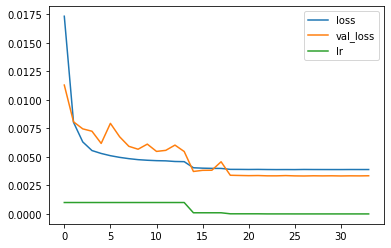

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
fraud_df.drop('isFraud', axis=1, inplace=True)
fraud_df.drop('TransactionID', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

fraud_X = scaler.fit_transform(fraud_df)
fraud_X

array([[0.75410972, 0.00527365, 0.85636825, ..., 0.        , 1.        ,
        0.47643226],
       [0.36837446, 0.00842043, 0.39149746, ..., 0.        , 1.        ,
        0.69598033],
       [0.993351  , 0.08567386, 0.07804569, ..., 1.        , 0.        ,
        0.69598033],
       ...,
       [0.15868363, 0.04810673, 0.52763036, ..., 1.        , 0.        ,
        0.69598033],
       [0.84633908, 0.01110793, 0.48805953, ..., 0.        , 1.        ,
        0.69598033],
       [0.96145552, 0.03032419, 0.66099446, ..., 0.        , 1.        ,
        0.59145259]])

In [ ]:
from tqdm import tqdm

mae = tf.keras.losses.MeanAbsoluteError()
fraud_losses = []
preds = autoencoder.predict(fraud_X, verbose=1)
with tqdm(total=preds.shape[0], unit='calc_error') as pbar:
  for index, record in enumerate(preds):
    fraud_losses.append(mae(fraud_X[index], record).numpy())
    pbar.update(1)


459/459 [==============================] - 1s 1ms/step


100%|██████████| 14682/14682 [00:10<00:00, 1395.52calc_error/s]


In [ ]:
train_losses = []
preds = autoencoder.predict(train_X, verbose=1)
with tqdm(total=preds.shape[0], unit='calc_error') as pbar:
  for index, record in enumerate(preds):
    train_losses.append(mae(train_X[index], record).numpy())
    pbar.update(1)

14571/14571 [==============================] - 25s 2ms/step


100%|██████████| 466256/466256 [05:33<00:00, 1399.99calc_error/s]


In [ ]:
df = pd.DataFrame.from_dict({
    'fraud': fraud_losses,
    'train': train_losses
}, orient='index')

df = df.transpose()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


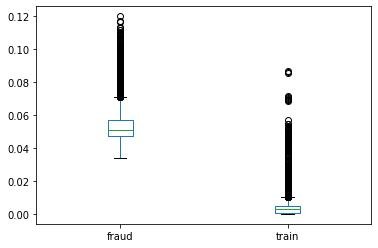

<Figure size 432x288 with 0 Axes>

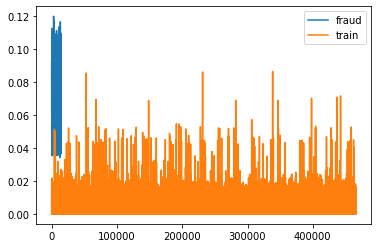

In [ ]:
df.plot(kind='box')
plt.figure()
df.plot()

In [ ]:
train_losses.sort()
fraud_losses.sort()
train_losses = np.array(train_losses)
fraud_losses = np.array(fraud_losses)

In [ ]:
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def calculate_accuracy_with_limit(fraud_np, train_np, limit):
  """
    has 3 return
      first: accuracy of correct prediction
      second: percent of correct fraud prediction
      third: percent of correct train prediction
  """
  f1 = find_nearest_index(fraud_np, limit)
  f2 = fraud_np.shape[0] - f1
  t1 = find_nearest_index(train_np, limit)
  t2 = train_np.shape[0] - t1
  su = f1 + f2 + t1 + t2
  return ((f2 + t1) / su * 100), ((f2 / (f1 + f2)) * 100), ((t1 / (t1 + t2)) * 100)


In [ ]:
limit = fraud_losses[0]
ac1, ac2, ac3 = calculate_accuracy_with_limit(fraud_losses, train_losses, limit)
print('method1')
print('accuracy if we set loss limit to {} is {:.4f}%.'.format(limit, ac1))
print('{:.4f}% of frauds were predicted correct and {:.4f}% of not fraud data has been predicted correctly'.format(ac2, ac3))
print('*' * 30)

limit = fraud_losses[int(fraud_losses.shape[0] / 4)]
ac1, ac2, ac3 = calculate_accuracy_with_limit(fraud_losses, train_losses, limit)
print('method2')
print('accuracy if we set loss limit to {} is {:.4f}%.'.format(limit, ac1))
print('{:.4f}% of frauds were predicted correct and {:.4f}% of not fraud data has been predicted correctly'.format(ac2, ac3))
print('*' * 30)

limit = train_losses[-1]
ac1, ac2, ac3 = calculate_accuracy_with_limit(fraud_losses, train_losses, limit)
print('method3')
print('accuracy if we set loss limit to {} is {:.4f}%.'.format(limit, ac1))
print('{:.4f}% of frauds were predicted correct and {:.4f}% of not fraud data has been predicted correctly'.format(ac2, ac3))
print('*' * 30)

q1 = fraud_losses[int(fraud_losses.shape[0] / 4)]
q3 = fraud_losses[int(fraud_losses.shape[0] / 4 * 3)]
r = q3 - q1
min_not_outlier_loss = q1 - 1.5 * r 
i = find_nearest_index(fraud_losses, min_not_outlier_loss)
limit = fraud_losses[i]
ac1, ac2, ac3 = calculate_accuracy_with_limit(fraud_losses, train_losses, limit)
print('method4')
print('accuracy if we set loss limit to {} is {:.4f}%.'.format(limit, ac1))
print('{:.4f}% of frauds were predicted correct and {:.4f}% of not fraud data has been predicted correctly'.format(ac2, ac3))
print('*' * 30)

best_loss = 1
best_ac = 0
for i in fraud_losses:
  a, _, _ = calculate_accuracy_with_limit(fraud_losses, train_losses, i)
  if best_ac < a:
    best_ac = a
    best_loss = i
limit = best_loss
ac1, ac2, ac3 = calculate_accuracy_with_limit(fraud_losses, train_losses, limit)
print('method5')
print('accuracy if we set loss limit to {} is {:.4f}%.'.format(limit, ac1))
print('{:.4f}% of frauds were predicted correct and {:.4f}% of not fraud data has been predicted correctly'.format(ac2, ac3))

method1
accuracy if we set loss limit to 0.034261591732501984 is 99.9728%.
100.0000% of frauds were predicted correct and 99.9719% of not fraud data has been predicted correctly
******************************
method2
accuracy if we set loss limit to 0.047241322696208954 is 99.2273%.
75.0034% of frauds were predicted correct and 99.9901% of not fraud data has been predicted correctly
******************************
method3
accuracy if we set loss limit to 0.08655508607625961 is 96.9726%.
0.8378% of frauds were predicted correct and 99.9998% of not fraud data has been predicted correctly
******************************
method4
accuracy if we set loss limit to 0.034261591732501984 is 99.9728%.
100.0000% of frauds were predicted correct and 99.9719% of not fraud data has been predicted correctly
******************************
method5
accuracy if we set loss limit to 0.03530906140804291 is 99.9732%.
99.9932% of frauds were predicted correct and 99.9725% of not fraud data has been predicted co

# Its All Done
just do all the above with train data and create submission file

## doinng identity

In [ ]:
# sample_submission_df = pd.read_csv('Proj3/sample_submission.csv')
test_identity_df = pd.read_csv('Proj3/test_identity.csv')
test_transaction_df = pd.read_csv('Proj3/test_transaction.csv')

In [ ]:
test_identity_df.info()

In [ ]:
test_transaction_df.info()

In [ ]:
col_to_delete = []
for i in test_identity_df.columns.to_list():
  nulls = test_identity_df[[i]].isnull().sum()[0]
  all = len(test_identity_df[[i]])
  print('column {}\t have {}\t null values which is {:.2f}%\t out of all'.format(i, nulls, nulls / all * 100), end=' ')
  print('this column has {}\t unique values'.format(len(test_identity_df[[i]].drop_duplicates())), 'column type is', test_identity_df[[i]].dtypes[0])
  if nulls / all * 100 > 40 and test_identity_df[[i]].dtypes[0] != np.object:
    col_to_delete.append(i)

col_to_delete

column TransactionID	 have 0	 null values which is 0.00%	 out of all this column has 141907	 unique values column type is int64
column id-01	 have 0	 null values which is 0.00%	 out of all this column has 80	 unique values column type is float64
column id-02	 have 4931	 null values which is 3.47%	 out of all this column has 114869	 unique values column type is float64
column id-03	 have 75426	 null values which is 53.15%	 out of all this column has 23	 unique values column type is float64
column id-04	 have 75426	 null values which is 53.15%	 out of all this column has 16	 unique values column type is float64
column id-05	 have 7157	 null values which is 5.04%	 out of all this column has 91	 unique values column type is float64
column id-06	 have 7157	 null values which is 5.04%	 out of all this column has 102	 unique values column type is float64
column id-07	 have 136848	 null values which is 96.43%	 out of all this column has 82	 unique values column type is float64
column id-08	 ha

['id-03',
 'id-04',
 'id-07',
 'id-08',
 'id-09',
 'id-10',
 'id-14',
 'id-18',
 'id-21',
 'id-22',
 'id-24',
 'id-25',
 'id-26',
 'id-32']

In [ ]:
print(col_to_delete)
print(col_to_delete1)

['id-03', 'id-04', 'id-07', 'id-08', 'id-09', 'id-10', 'id-14', 'id-18', 'id-21', 'id-22', 'id-24', 'id-25', 'id-26', 'id-32']
['id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32']


In [ ]:
test_identity_df.drop(col_to_delete, axis=1, inplace=True)

In [ ]:
col_to_onehot1 = []
for i in test_identity_df.columns.to_list():
  nulls = test_identity_df[[i]].isnull().sum()[0]
  all = len(test_identity_df[[i]])
  if test_identity_df[[i]].dtypes[0] == np.object and len(test_identity_df[[i]].drop_duplicates()) < 10:
    print('column {}\t have {}\t null values which is {:.2f}%\t out of all'.format(i, nulls, nulls / all * 100), end=' ')
    print('this column has {}\t unique values'.format(len(test_identity_df[[i]].drop_duplicates())), 'column type is', test_identity_df[[i]].dtypes[0])
    col_to_onehot1.append(i)


column id-12	 have 0	 null values which is 0.00%	 out of all this column has 2	 unique values column type is object
column id-15	 have 4930	 null values which is 3.47%	 out of all this column has 4	 unique values column type is object
column id-16	 have 16160	 null values which is 11.39%	 out of all this column has 3	 unique values column type is object
column id-23	 have 136845	 null values which is 96.43%	 out of all this column has 4	 unique values column type is object
column id-27	 have 136845	 null values which is 96.43%	 out of all this column has 3	 unique values column type is object
column id-28	 have 5129	 null values which is 3.61%	 out of all this column has 3	 unique values column type is object
column id-29	 have 5129	 null values which is 3.61%	 out of all this column has 3	 unique values column type is object
column id-34	 have 69732	 null values which is 49.14%	 out of all this column has 3	 unique values column type is object
column id-35	 have 4930	 null values whic

In [ ]:
print(col_to_onehot)
print(col_to_onehot1)

['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']
['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38', 'DeviceType']


In [ ]:
test_identity_df

TransactionID  id-01  ...  DeviceType                   DeviceInfo
0             3663586  -45.0  ...      mobile  MYA-L13 Build/HUAWEIMYA-L13
1             3663588    0.0  ...      mobile         LGLS676 Build/MXB48T
2             3663597   -5.0  ...     desktop                  Trident/7.0
3             3663601  -45.0  ...      mobile  MYA-L13 Build/HUAWEIMYA-L13
4             3663602  -95.0  ...      mobile         SM-G9650 Build/R16NW
...               ...    ...  ...         ...                          ...
141902        4170230  -20.0  ...      mobile                     SM-J700M
141903        4170233   -5.0  ...      mobile                     SM-J320M
141904        4170234   -5.0  ...      mobile                   iOS Device
141905        4170236  -45.0  ...      mobile  ALE-L23 Build/HuaweiALE-L23
141906        4170239  -10.0  ...      mobile                      SAMSUNG

[141907 rows x 27 columns]

we will saw than the order is diffrent in train and test data but its ok. we re order test dataframe after all preprocessings

In [ ]:
index = 0
while index < len(col_to_onehot1):
  tmp = set(test_identity_df[col_to_onehot1[index]].unique()) == set(train_identity_df[col_to_onehot[index]].unique())
  print(tmp)
  if not tmp:
    print(col_to_onehot1[index])
    print(set(test_identity_df[col_to_onehot1[index]].unique()))
    print(set(train_identity_df[col_to_onehot[index]].unique()))
    break
  tmp = pd.get_dummies(test_identity_df[[col_to_onehot1[index]]])
  test_identity_df.drop(col_to_onehot1[index], axis=1, inplace=True)
  test_identity_df = pd.concat([test_identity_df, tmp], axis=1)
  index += 1

True
True
True
True
True
True
True
False
DeviceInfo
{nan, 'match_status:2', 'match_status:1'}
{nan, 'match_status:0', 'match_status:2', 'match_status:1', 'match_status:-1'}


we must fix above. we just add 2 column that for all records it is 0

In [ ]:
print(col_to_onehot1[index])

tmp = pd.get_dummies(test_identity_df[[col_to_onehot1[index]]])
test_identity_df.drop(col_to_onehot1[index], axis=1, inplace=True)
test_identity_df = pd.concat([test_identity_df, tmp], axis=1)

tmp = pd.DataFrame({
    'id-34_match_status:-1': np.zeros(len(test_identity_df)),
    'id-34_match_status:0': np.zeros(len(test_identity_df))
})

test_identity_df = pd.concat([test_identity_df, tmp], axis=1)

index += 1

id-34


In [ ]:
while index < len(col_to_onehot1):
  tmp = set(test_identity_df[col_to_onehot1[index]].unique()) == set(train_identity_df[col_to_onehot[index]].unique())
  print(tmp)
  if not tmp:
    print(col_to_onehot1[index])
    print(set(test_identity_df[col_to_onehot1[index]].unique()))
    print(set(train_identity_df[col_to_onehot[index]].unique()))
    break
  tmp = pd.get_dummies(test_identity_df[[col_to_onehot1[index]]])
  test_identity_df.drop(col_to_onehot1[index], axis=1, inplace=True)
  test_identity_df = pd.concat([test_identity_df, tmp], axis=1)
  index += 1

True
True
True
True
True


done one hot them

In [ ]:
print(set(train_identity_df.id_30.unique()) == set(test_identity_df['id-30'].unique()))
print(set(train_identity_df.id_30.unique()) - set(test_identity_df['id-30'].unique()))
print(set(test_identity_df['id-30'].unique()) - set(train_identity_df.id_30.unique()))

False
{'Mac OS X 10_6_8'}
{'iOS 12.0.0', 'Mac OS X 10.14', 'iOS 12.0.1', 'iOS 12.1.1', 'iOS 12.1.0', 'Android 9', 'iOS 12.1.2', 'Mac OS X 10_14_1', 'Mac OS X 10_13_6', 'Mac OS X 10_14_2', 'Mac OS X 10_14', 'Mac OS X 10_14_0'}


In [ ]:
labels

['Android', 'iOS', 'Mac', 'Windows', 'Linux', 'func', 'other']

look above. same labels needed so its ok.

In [ ]:
tmp_arr = []
for i in test_identity_df['id-30'].values:
  if i is np.nan:
    tmp_arr.append(np.nan)
    continue
  if 'Android' in i:
    tmp_arr.append('Android')
  elif 'iOS' in i:
    tmp_arr.append('iOS')
  elif 'Mac' in i:
    tmp_arr.append('Mac')
  elif 'Windows' in i:
    tmp_arr.append('Windows')
  elif 'Linux' in i:
    tmp_arr.append('Linux')
  elif 'func' in i:
    tmp_arr.append('func')
  elif 'other' in i:
    tmp_arr.append('other')

In [ ]:
tmp = pd.get_dummies(pd.DataFrame({'id-30': tmp_arr}))

test_identity_df.drop('id-30', inplace=True, axis=1)

test_identity_df = pd.concat([test_identity_df, tmp], axis=1)

In [ ]:
import re

print(test_identity_df['id-31'].unique())

print('*' * 20)

new_arr = []
for i in test_identity_df['id-31'].unique():
  if i is np.nan:
    continue
  breaked = re.split(r'[0-9]+\.?[0-9]*', i)
  st = ''
  for j in breaked:
    if j.strip() == '':
      continue
    if j.replace(' ', '').replace('/', '').replace('-', '').isalpha():
      st += j.strip()
    else:
      print(j)
      raise  Exception()
  new_arr.append(st)
  

['chrome 67.0 for android' 'ie 11.0 for tablet' 'mobile safari 11.0'
 'chrome 67.0' 'ie 11.0 for desktop' 'mobile safari 10.0' 'edge 16.0' nan
 'chrome 65.0 for android' 'firefox 61.0' 'mobile safari 9.0'
 'samsung browser 7.2' 'safari 11.0' 'chrome 66.0' 'edge 17.0'
 'firefox 60.0' 'chrome 67.0 for ios' 'samsung browser 5.2'
 'chrome 56.0 for android' 'google search application 52.0'
 'chrome 50.0 for android' 'chrome 66.0 for ios' 'samsung browser 7.0'
 'firefox' 'safari 10.0' 'chrome 62.0 for android' 'firefox mobile 61.0'
 'firefox 48.0' 'safari 9.0' 'other' 'android webview 4.0' 'google'
 'chrome 55.0 for android' 'samsung' 'chrome 59.0 for android'
 'chrome 63.0 for android' 'chrome 66.0 for android' 'chrome 63.0'
 'chrome 65.0' 'firefox 62.0' 'chrome 64.0 for android' 'firefox 58.0'
 'firefox 52.0' 'firefox 59.0' 'chrome 49.0' 'chrome 59.0' 'chrome'
 'chrome 60.0' 'chrome 61.0 for android' 'mobile safari 12.0'
 'chrome 65.0 for ios' 'opera 53.0' 'edge 15.0' 'chrome 64.0'
 'andro

In [ ]:
print(set(new_arr) == set(new_arr1))
print(set(new_arr) - set(new_arr1))
print(set(new_arr1) - set(new_arr))

False
{'uc', 'rim', 'blackberry'}
{'firefox generic', 'Lanix/Ilium', 'Nokia/Lumia', 'chromium', 'android', 'safari generic', 'chrome generic for android', 'Samsung/SCH', 'Microsoft/Windows', 'seamonkey', 'line', 'maxthon', 'Samsung/SM-GH', 'iron', 'mobile safari uiwebview', 'Cherry', 'Mozilla/Firefox', 'aol', 'Generic/Android', 'cyberfox', 'Samsung/SM-GM', 'samsung browser generic', 'icedragon', 'chrome generic', 'LG/K-', 'MTel/M', 'comodo', 'opera generic', 'ZTE/Blade', 'waterfox', 'BLU/Dash', 'Inco/Minion', 'puffin', 'silk', 'mobile safari generic'}


there was no data about {'uc', 'rim', 'blackberry'} in train data. we threa them as "other" which is a catagory in both ones

In [ ]:
tmp_arr = []
for i in test_identity_df['id-31'].to_numpy():
  if i is np.nan:
    tmp_arr.append(0)
    continue
  if i in ['uc', 'rim', 'blackberry']:
    tmp_arr.append(id_31_labels['other'])
    continue
  breaked = re.split(r'[0-9]+\.?[0-9]*', i)
  st = ''
  for j in breaked:
    if j.strip() == '':
      continue
    if j.replace(' ', '').replace('/', '').replace('-', '').isalpha():
      st += j.strip()
  tmp_arr.append(id_31_labels[st])

assert len(tmp_arr) == len(test_identity_df)

test_identity_df.drop('id-31', axis=1, inplace=True)

tmp = pd.DataFrame({'id-31': tmp_arr})
test_identity_df = pd.concat([test_identity_df, tmp], axis=1)

In [ ]:
tmp3 = test_identity_df[['id-33']]
tmp4 = tmp3.notnull().astype(np.float32)

test_identity_df.drop('id-33', inplace=True, axis=1)

test_identity_df = pd.concat([test_identity_df, tmp4], axis=1)

In [ ]:
tmp3 = test_identity_df[['DeviceInfo']]
tmp4 = tmp3.notnull().astype(np.float32)

test_identity_df.drop('DeviceInfo', inplace=True, axis=1)

test_identity_df = pd.concat([test_identity_df, tmp4], axis=1)

In [ ]:
test_identity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141907 entries, 0 to 141906
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   TransactionID               141907 non-null  int64  
 1   id-01                       141907 non-null  float64
 2   id-02                       136976 non-null  float64
 3   id-05                       134750 non-null  float64
 4   id-06                       134750 non-null  float64
 5   id-11                       136778 non-null  float64
 6   id-13                       130286 non-null  float64
 7   id-17                       135966 non-null  float64
 8   id-19                       135906 non-null  float64
 9   id-20                       135633 non-null  float64
 10  id-12_Found                 141907 non-null  uint8  
 11  id-12_NotFound              141907 non-null  uint8  
 12  id-15_Found                 141907 non-null  uint8  
 13  id-15_New     

In [ ]:
for i in test_identity_df.columns.to_list():
  nulls = test_identity_df[[i]].isnull().sum()[0]
  all = len(test_identity_df[[i]])
  print('column {}\t have {}\t null values which is {:.2f}%\t out of all'.format(i, nulls, nulls / all * 100), end=' ')
  print('this column has {}\t unique values'.format(len(test_identity_df[[i]].drop_duplicates())), 'column type is', test_identity_df[[i]].dtypes[0])


column TransactionID	 have 0	 null values which is 0.00%	 out of all this column has 141907	 unique values column type is int64
column id-01	 have 0	 null values which is 0.00%	 out of all this column has 80	 unique values column type is float64
column id-02	 have 4931	 null values which is 3.47%	 out of all this column has 114869	 unique values column type is float64
column id-05	 have 7157	 null values which is 5.04%	 out of all this column has 91	 unique values column type is float64
column id-06	 have 7157	 null values which is 5.04%	 out of all this column has 102	 unique values column type is float64
column id-11	 have 5129	 null values which is 3.61%	 out of all this column has 302	 unique values column type is float64
column id-13	 have 11621	 null values which is 8.19%	 out of all this column has 28	 unique values column type is float64
column id-17	 have 5941	 null values which is 4.19%	 out of all this column has 104	 unique values column type is float64
column id-19	 have 6

we delete datas with one or more null values

In [ ]:
test_identity_df.dropna(inplace=True)

In [ ]:
test_identity_df

TransactionID  id-01     id-02  ...  id-31  id-33  DeviceInfo
0             3663586  -45.0  280290.0  ...     56    0.0         1.0
2             3663597   -5.0  185210.0  ...     24    0.0         1.0
3             3663601  -45.0  252944.0  ...     56    0.0         1.0
4             3663602  -95.0  328680.0  ...     56    0.0         1.0
5             3663622   -5.0   36786.0  ...     54    1.0         1.0
...               ...    ...       ...  ...    ...    ...         ...
141902        4170230  -20.0  473365.0  ...     56    0.0         1.0
141903        4170233   -5.0  489917.0  ...     56    0.0         1.0
141904        4170234   -5.0  110081.0  ...     54    1.0         1.0
141905        4170236  -45.0  266704.0  ...     56    0.0         1.0
141906        4170239  -10.0  692090.0  ...     48    0.0         1.0

[122691 rows x 50 columns]

In [ ]:
test_identity_transaction_ids = test_identity_df.TransactionID.values

test_identity_df.drop('TransactionID', inplace=True, axis=1)

In [ ]:
print(train_identity_df.columns.to_list())
print(test_identity_df.columns.to_list())

['id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20', 'id_12_Found', 'id_12_NotFound', 'id_15_Found', 'id_15_New', 'id_15_Unknown', 'id_16_Found', 'id_16_NotFound', 'id_23_IP_PROXY:ANONYMOUS', 'id_23_IP_PROXY:HIDDEN', 'id_23_IP_PROXY:TRANSPARENT', 'id_27_Found', 'id_27_NotFound', 'id_28_Found', 'id_28_New', 'id_29_Found', 'id_29_NotFound', 'id_34_match_status:-1', 'id_34_match_status:0', 'id_34_match_status:1', 'id_34_match_status:2', 'id_35_F', 'id_35_T', 'id_36_F', 'id_36_T', 'id_37_F', 'id_37_T', 'id_38_F', 'id_38_T', 'DeviceType_desktop', 'DeviceType_mobile', 'id_30_Android', 'id_30_Linux', 'id_30_Mac', 'id_30_Windows', 'id_30_func', 'id_30_iOS', 'id_30_other', 'id_31', 'id_33', 'DeviceInfo']
['id-01', 'id-02', 'id-05', 'id-06', 'id-11', 'id-13', 'id-17', 'id-19', 'id-20', 'id-12_Found', 'id-12_NotFound', 'id-15_Found', 'id-15_New', 'id-15_Unknown', 'id-16_Found', 'id-16_NotFound', 'id-23_IP_PROXY:ANONYMOUS', 'id-23_IP_PROXY:HIDDEN', 'id-23_IP_PROXY:TRAN

all row are alike but order is diffrent.  
the only diffrence is in id_34_* that we make it write by hand in next cell ;))

In [ ]:
cols = test_identity_df.columns.to_list()[:25] + ['id-34_match_status:-1', 'id-34_match_status:0', 'id-34_match_status:1', 'id-34_match_status:2'] + test_identity_df.columns.to_list()[29:]

In [ ]:
test_identity_df = test_identity_df[cols]
print(train_identity_df.columns.to_list())
print(test_identity_df.columns.to_list())

['id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20', 'id_12_Found', 'id_12_NotFound', 'id_15_Found', 'id_15_New', 'id_15_Unknown', 'id_16_Found', 'id_16_NotFound', 'id_23_IP_PROXY:ANONYMOUS', 'id_23_IP_PROXY:HIDDEN', 'id_23_IP_PROXY:TRANSPARENT', 'id_27_Found', 'id_27_NotFound', 'id_28_Found', 'id_28_New', 'id_29_Found', 'id_29_NotFound', 'id_34_match_status:-1', 'id_34_match_status:0', 'id_34_match_status:1', 'id_34_match_status:2', 'id_35_F', 'id_35_T', 'id_36_F', 'id_36_T', 'id_37_F', 'id_37_T', 'id_38_F', 'id_38_T', 'DeviceType_desktop', 'DeviceType_mobile', 'id_30_Android', 'id_30_Linux', 'id_30_Mac', 'id_30_Windows', 'id_30_func', 'id_30_iOS', 'id_30_other', 'id_31', 'id_33', 'DeviceInfo']
['id-01', 'id-02', 'id-05', 'id-06', 'id-11', 'id-13', 'id-17', 'id-19', 'id-20', 'id-12_Found', 'id-12_NotFound', 'id-15_Found', 'id-15_New', 'id-15_Unknown', 'id-16_Found', 'id-16_NotFound', 'id-23_IP_PROXY:ANONYMOUS', 'id-23_IP_PROXY:HIDDEN', 'id-23_IP_PROXY:TRAN

In [ ]:
test_identity_df = test_identity_df.astype(np.float64)
test_identity_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122691 entries, 0 to 141906
Data columns (total 49 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id-01                       122691 non-null  float64
 1   id-02                       122691 non-null  float64
 2   id-05                       122691 non-null  float64
 3   id-06                       122691 non-null  float64
 4   id-11                       122691 non-null  float64
 5   id-13                       122691 non-null  float64
 6   id-17                       122691 non-null  float64
 7   id-19                       122691 non-null  float64
 8   id-20                       122691 non-null  float64
 9   id-12_Found                 122691 non-null  float64
 10  id-12_NotFound              122691 non-null  float64
 11  id-15_Found                 122691 non-null  float64
 12  id-15_New                   122691 non-null  float64
 13  id-15_Unknown 

In [ ]:
test_identity_df.to_csv('drive/MyDrive/test_identity_df.csv')
np.savetxt("drive/MyDrive/w_simple_linear_identity_to_one_feature.csv", W, delimiter=",")

In [ ]:
new_feature = np.matmul(test_identity_df.values, W)
print(new_feature.shape)
new_feature

(122691,)


array([-33.9237936 ,   1.29839464, -38.2987936 , ...,  36.93074435,
       -42.6737936 ,  -0.29913576])

In [ ]:
test_identity_transaction_ids.shape

(122691,)

In [ ]:
test_identity_id_sum_df = pd.DataFrame({
    'TransactionId': test_identity_transaction_ids,
    'sum': new_feature
})

test_identity_id_sum_df.to_csv('drive/MyDrive/test_identity_id_sum_df.csv')

## now identity is done
lets process transaction data's

### pre process transaction df

In [ ]:
test_transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.5+ GB


In [ ]:
tmp = len(test_transaction_df)
for i in test_transaction_df.columns.to_list():
  nulls = test_transaction_df[[i]].isnull().sum()[0]
  all = len(test_transaction_df[[i]])
  print('column {}\t have {}\t null values which is {:.2f}% out of all'.format(i, nulls, nulls / all * 100), end=' ')
  print('this column has {}\t unique values'.format(len(test_transaction_df[[i]].drop_duplicates())), 'column type is', test_transaction_df[[i]].dtypes[0])

column TransactionID	 have 0	 null values which is 0.00% out of all this column has 506691	 unique values column type is int64
column TransactionDT	 have 0	 null values which is 0.00% out of all this column has 494686	 unique values column type is int64
column TransactionAmt	 have 0	 null values which is 0.00% out of all this column has 14119	 unique values column type is float64
column ProductCD	 have 0	 null values which is 0.00% out of all this column has 5	 unique values column type is object
column card1	 have 0	 null values which is 0.00% out of all this column has 13244	 unique values column type is int64
column card2	 have 8654	 null values which is 1.71% out of all this column has 498	 unique values column type is float64
column card3	 have 3002	 null values which is 0.59% out of all this column has 116	 unique values column type is float64
column card4	 have 3086	 null values which is 0.61% out of all this column has 5	 unique values column type is object
column card5	 have 4

In [ ]:
for i in range(322, 340):
  test_transaction_df.drop('V{}'.format(i), inplace=True, axis=1)

for i in range(138, 279):
  test_transaction_df.drop('V{}'.format(i), inplace=True, axis=1)

for i in range(1, 12):
  test_transaction_df.drop('V{}'.format(i), inplace=True, axis=1)

for i in range(35, 53):
  test_transaction_df.drop('V{}'.format(i), inplace=True, axis=1)

In [ ]:
tmp0 = test_transaction_df[['D{}'.format(i) for i in range(1, 16)]].fillna(0)

for i in range(1, 16):
  test_transaction_df.drop('D{}'.format(i), inplace=True, axis=1)

test_transaction_df = pd.concat([test_transaction_df, tmp0], axis=1)

In [ ]:
tmp1 = pd.get_dummies(test_transaction_df[['M{}'.format(i) for i in range(1, 10)]])

for i in range(1, 10):
  test_transaction_df.drop('M{}'.format(i), inplace=True, axis=1)

test_transaction_df = pd.concat([test_transaction_df, tmp1], axis=1)

In [ ]:
print(set(test_transaction_df.R_emaildomain.unique()) == set(train_transaction_df.R_emaildomain.unique()))
print(set(test_transaction_df.P_emaildomain.unique()) == set(train_transaction_df.P_emaildomain.unique()))

True
False


In [ ]:
print(set(test_transaction_df.P_emaildomain.unique()) - set(train_transaction_df.P_emaildomain.unique())) 
print(set(train_transaction_df.P_emaildomain.unique()) - set(test_transaction_df.P_emaildomain.unique()))
print(set(train_transaction_df.P_emaildomain.unique()))

test data have scranton.edu email domain where train data dont. we do not have anything to treat it like that so we have to treat it as null

In [ ]:
tmp2 = pd.get_dummies(test_transaction_df[['P_emaildomain', 'R_emaildomain']])

test_transaction_df.drop('P_emaildomain', inplace=True, axis=1)
test_transaction_df.drop('R_emaildomain', inplace=True, axis=1)

test_transaction_df = pd.concat([test_transaction_df, tmp2], axis=1)

In [ ]:
test_transaction_df.drop('P_emaildomain_scranton.edu', axis=1, inplace=True)

In [ ]:
tmp3 = test_transaction_df[['dist1', 'dist2']]
tmp4 = tmp3.notnull().astype(np.float32)

test_transaction_df.drop('dist1', inplace=True, axis=1)
test_transaction_df.drop('dist2', inplace=True, axis=1)

test_transaction_df = pd.concat([test_transaction_df, tmp4], axis=1)

In [ ]:
print(train_transaction_df.card4.unique())
print(test_transaction_df.card4.unique())
print(train_transaction_df.card6.unique())
print(test_transaction_df.card6.unique())

tmp5 = pd.get_dummies(test_transaction_df[['card4', 'card6']])

test_transaction_df.drop('card6', inplace=True, axis=1)
test_transaction_df.drop('card4', inplace=True, axis=1)

test_transaction_df = pd.concat([test_transaction_df, tmp5], axis=1)

['discover' 'mastercard' 'visa' 'american express' nan]
['visa' 'mastercard' 'american express' 'discover' nan]
['credit' 'debit' nan 'debit or credit' 'charge card']
['debit' 'credit' nan 'charge card']


In [ ]:
tmp6 = test_transaction_df[['addr1', 'addr2']]
tmp7 = tmp6.notnull().astype(np.float32)

test_transaction_df.drop('addr1', inplace=True, axis=1)
test_transaction_df.drop('addr2', inplace=True, axis=1)

test_transaction_df = pd.concat([test_transaction_df, tmp7], axis=1)

now processes are done.  
first we check column order  
then we can do 2 things:  
1. delete rows with null and consider them as they are not fraud
2. fill nulls with data

In [ ]:
# train_transaction_df.drop('isFraud', axis=1, inplace=True)

tmp1 = train_transaction_df.columns.to_list()
tmp2 = test_transaction_df.columns.to_list()

i = 2
while i < len(tmp1):
  if tmp1[i] != tmp2[i - 1]:
    print(tmp1[i], tmp2[i - 1], i)
    break
  else:
    print(True, end=' ')
  i += 1

True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True 

In [ ]:
tmp = len(test_transaction_df)
for i in test_transaction_df.columns.to_list():
  nulls = test_transaction_df[[i]].isnull().sum()[0]
  all = len(test_transaction_df[[i]])
  print('column {}\t have {}\t null values which is {:.2f}% out of all'.format(i, nulls, nulls / all * 100), end=' ')
  print('this column has {}\t unique values'.format(len(test_transaction_df[[i]].drop_duplicates())), 'column type is', test_transaction_df[[i]].dtypes[0])

column TransactionID	 have 0	 null values which is 0.00% out of all this column has 506691	 unique values column type is int64
column TransactionDT	 have 0	 null values which is 0.00% out of all this column has 494686	 unique values column type is int64
column TransactionAmt	 have 0	 null values which is 0.00% out of all this column has 14119	 unique values column type is float64
column ProductCD	 have 0	 null values which is 0.00% out of all this column has 5	 unique values column type is object
column card1	 have 0	 null values which is 0.00% out of all this column has 13244	 unique values column type is int64
column card2	 have 8654	 null values which is 1.71% out of all this column has 498	 unique values column type is float64
column card3	 have 3002	 null values which is 0.59% out of all this column has 116	 unique values column type is float64
column card5	 have 4547	 null values which is 0.90% out of all this column has 103	 unique values column type is float64
column C1	 have 3

In [ ]:
test_df = test_transaction_df.dropna(inplace=False)

print(test_df.ProductCD.unique())
print(train_df.ProductCD.unique())

tmp13 = pd.get_dummies(test_df[['ProductCD']])
test_df.drop('ProductCD', inplace=True, axis=1)
test_df = pd.concat([test_df, tmp13], axis=1)

test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

['W' 'S' 'C' 'R' 'H']
['W' 'C' 'S' 'H' 'R']


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


TransactionID  TransactionDT  ...  ProductCD_S  ProductCD_W
0             3992995       29703255  ...            0            0
1             4007311       30208388  ...            0            1
2             4105968       32935413  ...            0            1
3             3743983       21144908  ...            0            1
4             3802548       23208755  ...            0            1
...               ...            ...  ...          ...          ...
473918        4027157       30815527  ...            0            1
473919        3958333       28594625  ...            0            1
473920        4052507       31604888  ...            0            0
473921        3791403       22798315  ...            0            1
473922        3726043       20537720  ...            0            1

[473923 rows x 341 columns]

In [ ]:
import datetime

test_df.info()
test_df = test_df.astype(np.float32)
test_df.info()

hs = test_df[['TransactionDT']].values
mor = []
noon = []
nig = []
print(len(hs))
for hh in hs:
  h = datetime.datetime.utcfromtimestamp(hh).hour
  if 6 <= h and h <= 14:
    mor.append(1.0)
    noon.append(0)
    nig.append(0)
  elif 14 < h < 22:
    mor.append(0)
    noon.append(1.0)
    nig.append(0)
  else:
    mor.append(0)
    noon.append(0)
    nig.append(1.0)

print('mor: {}, noon: {}, night: {}'.format(len(mor), len(noon), len(nig)))
tmp = pd.DataFrame({
    'ismorning': mor,
    'isnoon': noon,
    'isnight': nig
})
print(len(tmp))
print(len(test_df))
test_df = pd.concat([test_df, tmp], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473923 entries, 0 to 473922
Columns: 341 entries, TransactionID to ProductCD_W
dtypes: float32(4), float64(184), int64(3), uint8(150)
memory usage: 751.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473923 entries, 0 to 473922
Columns: 341 entries, TransactionID to ProductCD_W
dtypes: float32(341)
memory usage: 616.5 MB
473923
mor: 473923, noon: 473923, night: 473923
473923
473923


In [ ]:
test_transaction_ids = test_df.TransactionID

test_df.drop('TransactionID', axis=1, inplace=True)

In [ ]:
test_identity_id_sum_df

TransactionId        sum
0             3663586 -33.923794
1             3663597   1.298395
2             3663601 -38.298794
3             3663602 -77.923794
4             3663622   6.430744
...               ...        ...
122686        4170230  -7.173794
122687        4170233 -17.673794
122688        4170234  36.930744
122689        4170236 -42.673794
122690        4170239  -0.299136

[122691 rows x 2 columns]

### now give test data to model

In [ ]:
train_df.to_csv('drive/MyDrive/train_df.csv')
test_df.to_csv('drive/MyDrive/test_df.csv')
test_transaction_ids.to_csv('drive/MyDrive/test_transaction_ids.csv')
test_identity_id_sum_df.to_csv('drive/MyDrive/test_identity_id_sum_df.csv')

In [ ]:
tmp1 = train_df.columns.to_list()
tmp2 = test_df.columns.to_list()

print(len(tmp1))
print(len(tmp2))

i = 0
while i < len(tmp1) - 2:
  if tmp1[i + 2] != tmp2[i]:
    print(tmp1[i + 2], tmp2[i], i)
    break
  else:
    print(True, end=' ')
  i += 1

345
343
True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True Tr

In [ ]:
from tqdm import tqdm

new_feature_list = []
with tqdm(total=len(test_df), unit='record') as pbar:
  for id in test_transaction_ids.to_numpy():
    try:
      tmp = np.where(test_identity_id_sum_df['TransactionId'].to_numpy() == id)[0][0]
      new_feature_list.append(test_identity_id_sum_df.iloc[tmp]['sum'])
    except IndexError:
      new_feature_list.append(0)
    finally:
      pbar.update(1)

print(len(new_feature_list))

tmp = pd.DataFrame({'identity': new_feature_list})
test_df = pd.concat([test_df, tmp], axis=1)

100%|██████████| 473923/473923 [01:25<00:00, 5574.12record/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
test_df

Unnamed: 0  TransactionDT  TransactionAmt  ...  isnoon  isnight   identity
0                0     29703256.0           10.39  ...     1.0      0.0 -23.054236
1                1     30208388.0           68.95  ...     1.0      0.0   0.000000
2                2     32935412.0          107.95  ...     0.0      1.0   0.000000
3                3     21144908.0           59.00  ...     1.0      0.0   0.000000
4                4     23208756.0           49.00  ...     0.0      0.0   0.000000
...            ...            ...             ...  ...     ...      ...        ...
473918      473918     30815528.0          226.00  ...     1.0      0.0   0.000000
473919      473919     28594624.0           49.00  ...     0.0      1.0   0.000000
473920      473920     31604888.0           25.00  ...     1.0      0.0  -6.196782
473921      473921     22798316.0          749.00  ...     1.0      0.0   0.000000
473922      473922     20537720.0         1002.00  ...     1.0      0.0   0.000000

[473923 rows x 345 columns]

In [ ]:
test_df.to_csv('drive/MyDrive/test_df_final.csv')

load data only if you want to start from here or your season has crashed

In [ ]:
test_df = pd.read_csv('drive/MyDrive/test_df_final.csv')

In [ ]:
test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
test_df

TransactionDT  TransactionAmt    card1  ...  isnoon  isnight   identity
0          29703256.0           10.39  15885.0  ...     1.0      0.0 -23.054236
1          30208388.0           68.95   8452.0  ...     1.0      0.0   0.000000
2          32935412.0          107.95  12544.0  ...     0.0      1.0   0.000000
3          21144908.0           59.00  17399.0  ...     1.0      0.0   0.000000
4          23208756.0           49.00  13108.0  ...     0.0      0.0   0.000000
...               ...             ...      ...  ...     ...      ...        ...
473918     30815528.0          226.00  17188.0  ...     1.0      0.0   0.000000
473919     28594624.0           49.00   4663.0  ...     0.0      1.0   0.000000
473920     31604888.0           25.00   4773.0  ...     1.0      0.0  -6.196782
473921     22798316.0          749.00   9500.0  ...     1.0      0.0   0.000000
473922     20537720.0         1002.00   7585.0  ...     1.0      0.0   0.000000

[473923 rows x 344 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
test_X = scaler.fit_transform(test_df)
print(test_X)

[[0.7146889  0.00100993 0.85559899 ... 1.         0.         0.54723436]
 [0.7466368  0.00671199 0.42831685 ... 1.         0.         0.61419211]
 [0.91911187 0.01050946 0.66354334 ... 0.         1.         0.61419211]
 ...
 [0.83496071 0.00243253 0.21683146 ... 1.         0.         0.59619444]
 [0.27797474 0.07292924 0.48856059 ... 1.         0.         0.61419211]
 [0.13499967 0.09756414 0.37847781 ... 1.         0.         0.61419211]]


In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Add

autoencoder_input = Input(344, name = 'input_autoencoder')

out1_encoder = Dense(344, activation='relu',name = 'encoder_layer1')(autoencoder_input)
out2_encoder = Dense(256, activation='relu',name = 'encoder_layer2')(out1_encoder)
out2_encoder = BatchNormalization(name = 'encoder_layer3')(out2_encoder)
out3_encoder = Dense(128, activation='relu',name = 'encoder_layer4')(out2_encoder)

in3_decoder = Dense(128, activation='relu',name = 'decoder_layer1')(out3_encoder)
in3_decoder = Add()([in3_decoder,out3_encoder])
in4_decoder = Dense(256, activation='relu',name = 'decoder_layer2')(in3_decoder)
in4_decoder = Add()([in4_decoder,out2_encoder])
in5_decoder = Dense(344, activation='relu',name = 'decoder_layer3')(in4_decoder)
in5_decoder = Add()([in5_decoder,out1_encoder])


autoencoder = tf.keras.models.Model(inputs=[autoencoder_input], outputs=[in5_decoder], name='auto_encoder')

autoencoder.summary()

Model: "auto_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_autoencoder (InputLayer)  [(None, 344)]        0                                            
__________________________________________________________________________________________________
encoder_layer1 (Dense)          (None, 344)          118680      input_autoencoder[0][0]          
__________________________________________________________________________________________________
encoder_layer2 (Dense)          (None, 256)          88320       encoder_layer1[0][0]             
__________________________________________________________________________________________________
encoder_layer3 (BatchNormalizat (None, 256)          1024        encoder_layer2[0][0]             
_______________________________________________________________________________________

In [ ]:
autoencoder.load_weights('drive/MyDrive/autoencoder_weights.hdf5')

In [ ]:
from tqdm import tqdm
import tensorflow as tf

mae = tf.keras.losses.MeanAbsoluteError()
losses = []
preds = autoencoder.predict(test_X, verbose=1)
with tqdm(total=preds.shape[0], unit='calc_error') as pbar:
  for index, record in enumerate(preds):
    losses.append(mae(test_X[index], record).numpy())
    pbar.update(1)

14811/14811 [==============================] - 22s 1ms/step


100%|██████████| 473923/473923 [04:53<00:00, 1615.45calc_error/s]


In [ ]:
ids = pd.read_csv('drive/MyDrive/test_transaction_ids.csv')

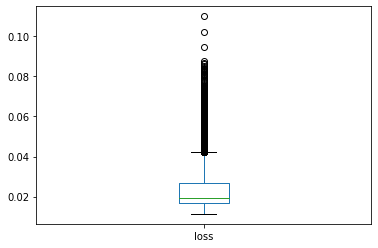

<Figure size 432x288 with 0 Axes>

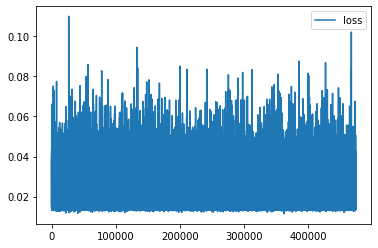

In [ ]:
df = pd.DataFrame({'loss': losses, 'TransactionID': ids.TransactionID.values})

df[['loss']].plot(kind='box')
plt.figure()
df[['loss']].plot()

In [ ]:
choosed_loss = 0.034261591732501984 

new_row = []

for i in losses:
  if i <= choosed_loss:
    new_row.append(0)
  else:
    new_row.append(1)

df = pd.concat([df, pd.DataFrame({'isFraud': new_row})], axis=1)

In [ ]:
df

loss  TransactionID  isFraud
0       0.038808      3992995.0        1
1       0.017299      4007311.0        0
2       0.016909      4105968.0        0
3       0.015244      3743983.0        0
4       0.015169      3802548.0        0
...          ...            ...      ...
473918  0.020270      4027157.0        0
473919  0.016286      3958333.0        0
473920  0.027609      4052507.0        0
473921  0.019075      3791403.0        0
473922  0.014753      3726043.0        0

[473923 rows x 3 columns]

we add deleted datas as not fraud

In [ ]:
test_transaction_df = pd.read_csv('Proj3/test_transaction.csv')

In [ ]:
id_set = set(test_transaction_df.TransactionID.to_list()) - set(df.TransactionID.to_list())
print(len(id_set))
id_set

32768


{3801088,
 3801089,
 3801090,
 3801091,
 3801092,
 3801093,
 3670022,
 3801094,
 3670024,
 3801095,
 3801096,
 3801097,
 3801098,
 3801099,
 3670030,
 3801100,
 3801101,
 3801102,
 3801103,
 3801105,
 3670036,
 3801107,
 3670038,
 3801108,
 3801104,
 3670041,
 3801114,
 3670043,
 3801115,
 3801116,
 3801109,
 3670047,
 3670048,
 3801112,
 3801122,
 3801117,
 3801118,
 3801125,
 3801126,
 3801119,
 3801128,
 3801129,
 3801130,
 3801131,
 3670060,
 3801133,
 3933796,
 3933797,
 3801136,
 3801137,
 3801132,
 3801134,
 3670068,
 3670069,
 3801140,
 3670071,
 3801143,
 3801138,
 3801146,
 3801139,
 3801141,
 3801142,
 3801144,
 3670079,
 3801151,
 3801152,
 3670082,
 3801153,
 3801155,
 3801156,
 3670086,
 3801157,
 3801158,
 3801159,
 3801160,
 3801161,
 3801162,
 3801163,
 3801164,
 3801165,
 3801166,
 3801169,
 3801167,
 3801171,
 3801168,
 3801173,
 3801174,
 3670103,
 3801175,
 3801170,
 3801178,
 3801172,
 3801180,
 3801181,
 3801182,
 3801183,
 3801176,
 3801177,
 3801186,
 3801187,


In [ ]:
tmp = pd.DataFrame({'loss': np.zeros(len(id_set)), 'TransactionID': list(id_set), 'isFraud': np.zeros(len(id_set))})
tmp

loss  TransactionID  isFraud
0       0.0        3801088      0.0
1       0.0        3801089      0.0
2       0.0        3801090      0.0
3       0.0        3801091      0.0
4       0.0        3801092      0.0
...     ...            ...      ...
32763   0.0        3801083      0.0
32764   0.0        3801084      0.0
32765   0.0        3801085      0.0
32766   0.0        3801086      0.0
32767   0.0        3801087      0.0

[32768 rows x 3 columns]

In [ ]:
df = df.append(tmp, ignore_index = True) 

In [ ]:
df

loss  TransactionID  isFraud
0       0.038808      3992995.0      1.0
1       0.017299      4007311.0      0.0
2       0.016909      4105968.0      0.0
3       0.015244      3743983.0      0.0
4       0.015169      3802548.0      0.0
...          ...            ...      ...
506686  0.000000      3801083.0      0.0
506687  0.000000      3801084.0      0.0
506688  0.000000      3801085.0      0.0
506689  0.000000      3801086.0      0.0
506690  0.000000      3801087.0      0.0

[506691 rows x 3 columns]

# Last statistics

In [ ]:
print('number of predicted frauds: {} which is {:.2f}% of all test data'.format(int(df.isFraud.sum()), df.isFraud.sum() / len(df) * 100))
print('meanns {} number of data s are not fraud'.format(int(len(df) - df.isFraud.sum())))

number of predicted frauds: 28667 which is 5.66% of all test data
meanns 478024 number of data s are not fraud


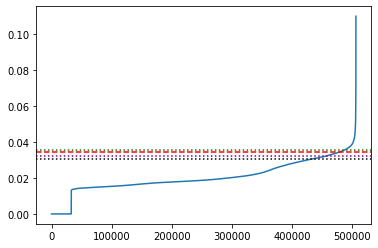

In [ ]:
df = df.sort_values(by='loss', ignore_index=True)

fig = plt.Figure(figsize=(14, 6))
plt.plot(df[['loss']])
plt.axhline(choosed_loss, color='red', ls='--')             # model 3 min fraud after delete outliers
plt.axhline(0.03530906140804291, color='green', ls=':')     # model 3 best accuracy
plt.axhline(0.030795792117714882, color='black', ls=':')    # model 2 min fraud after delete outliers
plt.axhline(0.032493650913238525, color='purple', ls=':')   # model 2 best accuracy
# {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}

In [ ]:
df.drop('loss', axis=1).to_csv('drive/MyDrive/submission.csv')

# check submission

In [ ]:
df = pd.read_csv('drive/MyDrive/submission.csv')

In [ ]:
df

Unnamed: 0  TransactionID  isFraud
0                0      3801087.0      0.0
1                1      3703765.0      0.0
2                2      4140803.0      0.0
3                3      3703724.0      0.0
4                4      3703815.0      0.0
...            ...            ...      ...
506686      506686      3762320.0      1.0
506687      506687      3762322.0      1.0
506688      506688      4023992.0      1.0
506689      506689      4023996.0      1.0
506690      506690      4024002.0      1.0

[506691 rows x 3 columns]